# Customer Segmentation Based on Marketing Dataset

---

## Objectives and info:

** Determine customer segmentation based on purchase patterns:**
- The dataset has 35116 observations for previous international transactions.
- The observations span 37 different countries.
- There is no target variable.

** We have the following features:**
    
** Invoice information:**
- 'InvoiceNo'– Unique ID for invoice 
- 'InvoiceDate' – Invoice date

** Item information:**
- 'StockCode'– Unique ID for item
-  'Description' – Text description for item
- 'Quantity' – Units per pack for item
- 'UnitPrice' – Price per unit in GBP

**Customer information:**
-  'CustomerID' – Unique ID for customer 
- 'Country' – Country of customer

## 1. Data Preparation

### 1.1 Import libraries and load data


First we import all libraries and classes that we will use in data manipulation, data mining and visualisation

In [29]:
# import libraries for data manipulation
import numpy as np 
import pandas as pd

# import libraries for visualisation/plots/graphs
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
#warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
import itertools
from pathlib import Path

# import libraries for data mining and data analysis
from sklearn import neighbors
from sklearn.model_selection  import cross_val_score
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Import libraries for date, time and datetime manipulation
import datetime as dt

# confirguration and formatting
import warnings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.options.display.max_columns = 100

As a second step, we load a dataset that we will analyze in this project. 
The dataset contain various customer' information, such as volume of purchases, what did the customer bought, how much the customer paied for each item, and other information related to each order/invoice.
The goal of the project is to determine any similarities between these customers based on their purchases made over a period of one year,  in order to help the Marketing team to target the customers in the future with personal offers and focus more on the customer's need.

### 1.2 Data Exploration - validation and new variables
- get basic informations on the content of the dataframe
- merge the two dataframes, based on StockCode, to get the main category for our purchased items, which will help us to get a better understanding of our customer's behaviour
- look at the type of various variables,
- check if any null values and
- create the percentage with respect to the total number of entries:

In [30]:
# reading the main datafile:
df_initial = pd.read_csv('purchase_patterns.csv')

# reading the second datafile and create names for the two variables:
df_prod_cat = pd.read_csv('Stock_Code_Cat_Unique.csv')
df_prod_cat.columns = ["StockCode","Category"]

# let's look at the main dataframe and diplay a description of the dataset:
print('\033[1m'+'\x1b[4;32;47m'+'Main Dataframe dimensions:'+ '\x1b[0m'+'\033[0m', df_initial.shape)
print('')
#print('Second Dataframe dimensions:', df_prod_cat.shape)

# convert the InvoiceData from object to datetime:
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
# drop the column created by the csv file:
df_initial=df_initial.drop(columns='Unnamed: 0',axis=1)

# give some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
#__________________
# show first lines
print(' ')
display(df_initial[:5])

print('')
print('')
print('\033[1m'+'\x1b[4;32;47m'+'Second Dataframe dimensions:'+ '\x1b[0m'+'\033[0m', df_prod_cat.shape)

#__________________
# show first lines
print(' ')
display(df_prod_cat[:5])

# merge the two dataframes on StockCode
df_initial = df_initial.merge(df_prod_cat[['StockCode','Category']], on=['StockCode'])

Main Dataframe dimensions: (35116, 9)



InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type          int64    object      object    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)          0         0           0        0               0   

                 UnitPrice CustomerID Country  
column type        float64    float64  object  
null values (nb)         0       1418       0  
null values (%)          0    4.03805       0

InvoiceNo StockCode                      Description  Quantity  \
0     536370     22728        ALARM CLOCK BAKELIKE PINK        24   
1     536370     22727        ALARM CLOCK BAKELIKE RED         24   
2     536370     22726       ALARM CLOCK BAKELIKE GREEN        12   
3     536370     21724  PANDA AND BUNNIES STICKER SHEET        12   
4     536370     21883                 STARS GIFT TAPE         24   

          InvoiceDate  UnitPrice  CustomerID Country  
0 2010-12-01 08:45:00       3.75     12583.0  France  
1 2010-12-01 08:45:00       3.75     12583.0  France  
2 2010-12-01 08:45:00       3.75     12583.0  France  
3 2010-12-01 08:45:00       0.85     12583.0  France  
4 2010-12-01 08:45:00       0.65     12583.0  France



Second Dataframe dimensions: (2573, 2)
 


StockCode      Category
0     10120          MISC
1     10125  GIFT & PARTY
2     10133        CRAFTS
3     10135        CRAFTS
4     11001        CRAFTS

Looking at the stats table, we can see that there are around 1400 (4% of total) missing values in the CustomerID column.
Since our analysis is based on customers information, we will** remove these missing values**. 

In [31]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('\033[1m'+'\x1b[4;32;47m'+'Dataframe dimensions:'+ '\x1b[0m'+'\033[0m', df_initial.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (33686, 9)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type          int64    object      object    int64  datetime64[ns]   
null values (nb)         0         0           0        0               0   
null values (%)          0         0           0        0               0   

                 UnitPrice CustomerID Country Category  
column type        float64    float64  object   object  
null values (nb)         0          0       0        0  
null values (%)          0          0       0        0

By removing all rows with NaN values, we now have a dataframe which is filled with needed values 100% for all variables.

Finally, we are going to check for duplicates at row/entry level and drop them if any:

In [32]:
# check for duplicates at entry level
print('\033[1m'+'\x1b[4;32;47m'+'Number of duplicates that we removed:'+ '\x1b[0m'+'\033[0m', df_initial.duplicated().sum())

# drop duplicates
df_initial.drop_duplicates(inplace = True)

Number of duplicates that we removed: 64


Let's check the results by looking at the stats:

In [33]:
# look at the stats for all features

#df.describe(include='all')
np.transpose(df_initial.describe(include='all'))


count unique                  top  freq                first  \
InvoiceNo    33622    NaN                  NaN   NaN                  NaN   
StockCode    33622   2573                 POST  1055                  NaN   
Description  33622   2638              POSTAGE  1055                  NaN   
Quantity     33622    NaN                  NaN   NaN                  NaN   
InvoiceDate  33622   1523  2011-10-11 14:52:00   259  2010-12-01 08:45:00   
UnitPrice    33622    NaN                  NaN   NaN                  NaN   
CustomerID   33622    NaN                  NaN   NaN                  NaN   
Country      33622     36              Germany  9024                  NaN   
Category     33622     15            HOME WARE  8704                  NaN   

                            last     mean      std     min     25%     50%  \
InvoiceNo                    NaN   559914  12715.9  536370  548363  561093   
StockCode                    NaN      NaN      NaN     NaN     NaN     NaN   
Description                  NaN      NaN      NaN     NaN     NaN     NaN   
Quantity                     NaN  14.8114  31.7106       1       5      10   
InvoiceDate  2011-12-09 12:50:00      NaN      NaN     NaN     NaN     NaN   
UnitPrice                    NaN  4.48495  47.2323    0.04    1.25    1.95   
CustomerID                   NaN  12793.9  828.701   12347   12473   12597   
Country                      NaN      NaN      NaN     NaN     NaN     NaN   
Category                     NaN      NaN      NaN     NaN     NaN     NaN   

                75%      max  
InvoiceNo    570672   581587  
StockCode       NaN      NaN  
Description     NaN      NaN  
Quantity         12     2040  
InvoiceDate     NaN      NaN  
UnitPrice      3.75  4161.06  
CustomerID    12708    17844  
Country         NaN      NaN  
Category        NaN      NaN

Have a look at count of unique values for objets columns as well:

In [34]:
# have a look at unique values for those columns with datatype =object
unique_values=['InvoiceNo', 'Quantity', 'UnitPrice', 'CustomerID','Country', 'Category']

for i in unique_values:
  print("There are "+'\033[1m'+ str(df_initial[i].nunique())+'\033[0m' +" unique " + i + " in the DataFrame")

There are 1536 unique InvoiceNo in the DataFrame
There are 80 unique Quantity in the DataFrame
There are 168 unique UnitPrice in the DataFrame
There are 414 unique CustomerID in the DataFrame
There are 36 unique Country in the DataFrame
There are 15 unique Category in the DataFrame


### 1.3 Exploring the content of variables
This dataframe contains 8 variables that correspond to:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates a cancellation. 

- StockCode: Product/item code. Number uniquely assigned to each distinct product. 

- Description: Product/item name. Nominal. 

- Quantity: The quantities of each product (item) per transaction. Numeric. 

- InvoiceDate: When each transaction was generated. 

- UnitPrice: Unit price. Numeric, Product price per unit

- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 

- Country: Country name. Nominal, the name of the country where each customer resides.

- Category: the main class for each item

In [35]:
# let's have a look at orders' distribution per country
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Countries that placed at least one order in the given year :  {}'.format(len(countries)))
print('')
countries

Countries that placed at least one order in the given year :  36



Germany                 457
France                  389
Belgium                  98
Spain                    90
Portugal                 57
Switzerland              51
Finland                  41
Italy                    38
Norway                   36
Australia                36
Sweden                   36
Channel Islands          26
Netherlands              21
Poland                   19
Japan                    19
Denmark                  18
Austria                  17
Cyprus                   16
Unspecified               8
Iceland                   7
Singapore                 7
Canada                    6
Greece                    5
Israel                    5
USA                       5
Malta                     5
European Community        4
Lithuania                 4
EIRE                      4
United Arab Emirates      3
Czech Republic            2
Bahrain                   2
Saudi Arabia              1
RSA                       1
Lebanon                   1
Brazil              

As you can see, almost **half of orders/ invoices** in a year, have been placed by Customers form **Germany and France**.

In [36]:
# not working in colab
#---------------------
# show the above figures on a world map:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Number of orders'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)

layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'Mercator'}))


choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

How many distinct products, distinct transactions/invoices and distinct customers we have in our dataframe?

Is there any negative values on the UnitPrice variables?

In [37]:
# counts of products, transactions, customers:
print(pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['Volumes']))

print('')

# check if any negative values on the UnitPrice column
df_check = df_initial[df_initial['UnitPrice'] < 0]
print('Number of entries with negative values :  {}'.format(len(df_check)))

         products  transactions  customers
Volumes      2573          1536        414

Number of entries with negative values :  0


In [38]:
# check if any Disocunts 
df_check =  df_initial[df_initial['Description'] == 'Discount']
print('Number discounts :  {}'.format(len(df_check)))

Number discounts :  0


In [39]:
# is there any special codes?
list_special_codes = df_initial[df_initial['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'C2', 'M'], dtype=object)

How much did a customer paid per invoice?
in order to answer this, we need to create a new variables that will contain the total value, based on Quantity and UnitPrice:

In [40]:
df_initial['TotalPrice'] = df_initial['UnitPrice'] * (df_initial['Quantity'])
df_initial.sort_values('CustomerID')[:5]

InvoiceNo StockCode                   Description  Quantity  \
18992     556201     85178          VICTORIAN SEWING KIT        12   
27894     573511     22371  AIRLINE BAG VINTAGE TOKYO 78        12   
30671     556201     17021        NAMASTE SWAGAT INCENSE        36   
140       556201     22727     ALARM CLOCK BAKELIKE RED          8   
27888     562032     22371  AIRLINE BAG VINTAGE TOKYO 78         8   

              InvoiceDate  UnitPrice  CustomerID  Country   Category  \
18992 2011-06-09 13:01:00       1.25     12347.0  Iceland     CRAFTS   
27894 2011-10-31 12:25:00       3.95     12347.0  Iceland       BAGS   
30671 2011-06-09 13:01:00       0.30     12347.0  Iceland       MISC   
140   2011-06-09 13:01:00       3.75     12347.0  Iceland  HOME WARE   
27888 2011-08-02 08:48:00       4.25     12347.0  Iceland       BAGS   

       TotalPrice  
18992        15.0  
27894        47.4  
30671        10.8  
140          30.0  
27888        34.0

### 1.3 A clean dataframe, which has the aggregated info at customer level

---

We are going to aggregate all info at customer level, step by step and merge it to the output table

In [41]:
df_out = pd.DataFrame(data=df_initial['CustomerID'].unique(), columns=['CustomerID']).sort_values('CustomerID')
df_out.head()

CustomerID
2       12347.0
244     12348.0
168     12349.0
268     12350.0
214     12352.0

In [42]:
df_initial['TotalPrice'] = df_initial['UnitPrice'] * (df_initial['Quantity'])
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

temp_t_v = df_initial.groupby(by=['CustomerID'], as_index=False)['TotalPrice'].sum()
temp_t_v.head()

df_out = df_out.merge(temp_t_v[['CustomerID','TotalPrice']], on=['CustomerID'])
df_out.rename(columns={"TotalPrice": "TotalValue"}, inplace=True)

#total price per invoice
temp_t_p_i = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
temp_t_p_i.head()

temp_t_p_i = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
temp_t_p_i.head()

temp_min_id_p_c = df_initial.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].min()
temp_max_id_p_c = df_initial.groupby(by=['CustomerID'], as_index=False)['InvoiceDate'].max()


temp_t_p_i_min = temp_t_p_i.groupby(by=['CustomerID'], as_index=False)['TotalPrice'].min()
temp_t_p_i_max = temp_t_p_i.groupby(by=['CustomerID'], as_index=False)['TotalPrice'].max()
temp_t_p_i_avg = temp_t_p_i.groupby(by=['CustomerID'], as_index=False)['TotalPrice'].mean()


df_out = df_out.merge(temp_t_p_i_min[['CustomerID','TotalPrice']], on=['CustomerID'])
df_out.rename(columns={"TotalPrice": "min_inv_val"}, inplace=True)


df_out = df_out.merge(temp_t_p_i_max[['CustomerID','TotalPrice']], on=['CustomerID'])
df_out.rename(columns={"TotalPrice": "max_inv_val"}, inplace=True)

df_out = df_out.merge(temp_t_p_i_avg[['CustomerID','TotalPrice']], on=['CustomerID'])
df_out.rename(columns={"TotalPrice": "avg_inv_val"}, inplace=True)

df_out = df_out.merge(temp_min_id_p_c[['CustomerID','InvoiceDate']], on=['CustomerID'])
df_out.rename(columns={"InvoiceDate": "min_inv_dt"}, inplace=True)

df_out = df_out.merge(temp_max_id_p_c[['CustomerID','InvoiceDate']], on=['CustomerID'])
df_out.rename(columns={"InvoiceDate": "max_inv_dt"}, inplace=True)

df_out['order_dt_range'] = 0

df_out['order_dt_range'] = (df_out['max_inv_dt'] - df_out['min_inv_dt']).astype('timedelta64[D]')

temp_inv_c_p_c = df_initial.groupby(by=['CustomerID','InvoiceNo'], as_index=False)['StockCode'].count()
temp_inv_c_p_c2 = temp_inv_c_p_c.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()

df_out = df_out.merge(temp_inv_c_p_c2[['CustomerID','InvoiceNo']], on=['CustomerID'])
df_out.rename(columns={"InvoiceNo": "total_orders"}, inplace=True)

temp_total_prod_line = df_initial.groupby(by=['CustomerID'], as_index=False)['StockCode'].count()
df_out = df_out.merge(temp_total_prod_line[['CustomerID','StockCode']], on=['CustomerID'])
df_out.rename(columns={"StockCode": "total_prod_line"}, inplace=True)

df_out['avg_prod_line_p_inv'] = 0
df_out['avg_prod_line_p_inv'] = round(df_out['total_prod_line'] / df_out['total_orders'])


df_out.head()

CustomerID  TotalValue  min_inv_val  max_inv_val  avg_inv_val  \
0     12347.0     4310.00       224.82      1294.32   615.714286   
1     12348.0     1797.24       227.44       892.80   449.310000   
2     12349.0     1757.55      1757.55      1757.55  1757.550000   
3     12350.0      334.40       334.40       334.40   334.400000   
4     12352.0     2506.04       120.33       840.30   313.255000   

           min_inv_dt          max_inv_dt  order_dt_range  total_orders  \
0 2010-12-07 14:57:00 2011-12-07 15:52:00           365.0             7   
1 2010-12-16 19:09:00 2011-09-25 13:13:00           282.0             4   
2 2011-11-21 09:51:00 2011-11-21 09:51:00             0.0             1   
3 2011-02-02 16:01:00 2011-02-02 16:01:00             0.0             1   
4 2011-02-16 12:33:00 2011-11-03 14:37:00           260.0             8   

   total_prod_line  avg_prod_line_p_inv  
0              182                 26.0  
1               31                  8.0  
2               73                 73.0  
3               17                 17.0  
4               85                 11.0

In [43]:
# Map Continents to each Country in our main dataframe
df_initial['Continent'] = df_initial['Country']
df_initial['Continent'] = df_initial['Continent'].apply(
    lambda x: 'Europe' 
        if (x in ('Austria','Belgium','Channel Islands','Cyprus','Czech Republic','Denmark','EIRE',
                  'European Community','Finland','France','Germany','Greece','Iceland','Israel','Italy','Lithuania',
                    'Malta','Netherlands','Norway','Poland','Portugal','Spain','Sweden','Switzerland'
                 )
           ) 
            else 
                (
                    'Africa' if (x =='RSA') 
                                else (
                                        'Asia' if (x in ('Bahrain','Hong Kong','Japan','Lebanon','Saudi Arabia',
                                                         'Singapore','United Arab Emirates'
                                                        )
                                                  ) 
                                                    else 
                                                        (
                                                            'Australias' if (x=='Australia') 
                                                                else ('North America' if (x in ('Canada','USA'))
                                                                                        else 
                                                                                            ('South America' if (x=='Brazil') 
                                                                                                                else 'Unknown'
                                                                                             )         
                                                                      )  
                                                          )
                                        )
                )
        ) 
df_initial.head()

InvoiceNo StockCode                Description  Quantity  \
0     536370     22728  ALARM CLOCK BAKELIKE PINK        24   
1     537065     22728  ALARM CLOCK BAKELIKE PINK         4   
2     537626     22728  ALARM CLOCK BAKELIKE PINK         4   
3     538003     22728  ALARM CLOCK BAKELIKE PINK        12   
4     538174     22728  ALARM CLOCK BAKELIKE PINK        24   

          InvoiceDate  UnitPrice  CustomerID  Country   Category  TotalPrice  \
0 2010-12-01 08:45:00       3.75     12583.0   France  HOME WARE        90.0   
1 2010-12-05 11:57:00       3.75     12567.0   France  HOME WARE        15.0   
2 2010-12-07 14:57:00       3.75     12347.0  Iceland  HOME WARE        15.0   
3 2010-12-09 12:05:00       3.75     12429.0  Denmark  HOME WARE        45.0   
4 2010-12-10 09:35:00       3.75     12471.0  Germany  HOME WARE        90.0   

  Continent  
0    Europe  
1    Europe  
2    Europe  
3    Europe  
4    Europe

In [44]:
# aggregate/manipulate the following columns in order to add them to the output table
temp_continent = df_initial.groupby(by=['CustomerID'], as_index=False)['Continent'].min()
df_out = df_out.merge(temp_continent[['CustomerID','Continent']], on=['CustomerID'])

df_out['min_inv_dt'] = df_out['min_inv_dt'].dt.normalize()
df_out['max_inv_dt'] = df_out['max_inv_dt'].dt.normalize()

df_out['min_inv_val'] = round(df_out['min_inv_val'],0)
df_out['max_inv_val'] = round(df_out['max_inv_val'],0)
df_out['avg_inv_val'] = round(df_out['avg_inv_val'],0)

temp_inv_date = df_initial.groupby(by=['CustomerID','InvoiceNo'], as_index=False)['InvoiceDate'].min()
temp_inv_date['wdays'] = temp_inv_date['InvoiceDate'].dt.dayofweek

temp_inv_date['week'] = 0
temp_inv_date['wend'] = 0

#0-4 : weekdays, 5-6 : weekend

temp_inv_date['week'] = temp_inv_date['wdays'].apply(lambda x : 1 if (x >=0 and x<=4) else 0)
temp_inv_date['wend'] = temp_inv_date['wdays'].apply(lambda x : 1 if (x >=5 and x<=6) else 0)

In [45]:
# visualize the dataframe
temp_inv_date.head()

CustomerID  InvoiceNo         InvoiceDate  wdays  week  wend
0     12347.0     537626 2010-12-07 14:57:00      1     1     0
1     12347.0     542237 2011-01-26 14:30:00      2     1     0
2     12347.0     549222 2011-04-07 10:43:00      3     1     0
3     12347.0     556201 2011-06-09 13:01:00      3     1     0
4     12347.0     562032 2011-08-02 08:48:00      1     1     0

In [46]:
# manipulate the date column in order to create the number of transations per weekdays and weekends
temp_w1 = temp_inv_date.groupby(by=['CustomerID'], as_index=False)['week'].sum()
temp_w2 = temp_inv_date.groupby(by=['CustomerID'], as_index=False)['wend'].sum()

temp_w1.head()

CustomerID  week
0     12347.0     7
1     12348.0     3
2     12349.0     1
3     12350.0     1
4     12352.0     8

Add the new variables created at the final output table:

In [47]:
# using merge function, we are going to add the two new columns to our df_out
df_out = df_out.merge(temp_w1[['CustomerID','week']], on=['CustomerID'])
df_out = df_out.merge(temp_w2[['CustomerID','wend']], on=['CustomerID'])

df_out.head()

CustomerID  TotalValue  min_inv_val  max_inv_val  avg_inv_val min_inv_dt  \
0     12347.0     4310.00        225.0       1294.0        616.0 2010-12-07   
1     12348.0     1797.24        227.0        893.0        449.0 2010-12-16   
2     12349.0     1757.55       1758.0       1758.0       1758.0 2011-11-21   
3     12350.0      334.40        334.0        334.0        334.0 2011-02-02   
4     12352.0     2506.04        120.0        840.0        313.0 2011-02-16   

  max_inv_dt  order_dt_range  total_orders  total_prod_line  \
0 2011-12-07           365.0             7              182   
1 2011-09-25           282.0             4               31   
2 2011-11-21             0.0             1               73   
3 2011-02-02             0.0             1               17   
4 2011-11-03           260.0             8               85   

   avg_prod_line_p_inv Continent  week  wend  
0                 26.0    Europe     7     0  
1                  8.0    Europe     3     1  
2                 73.0    Europe     1     0  
3                 17.0    Europe     1     0  
4                 11.0    Europe     8     0

**Now we are going to use the pivot_table function, to aggregate the TotalValue per each item(UnitPrice*Quantity) per each customer ** 

In [48]:
# using pivot table, we aggregate the total price paid by each customer for each item/category
df_temp = pd.pivot_table(df_initial,index=['CustomerID'], values='TotalPrice', columns=['Category'], 
                         aggfunc = np.sum )
df_temp.head()

Category     BAGS  BAKING  CARRIAGE & POST  CRAFTS  GAMES & TOYS  \
CustomerID                                                         
12347.0     451.9  402.45              NaN  163.20         510.3   
12348.0       NaN  507.60            360.0  301.20           NaN   
12349.0       NaN  107.86            300.0   63.03           NaN   
12350.0      20.4     NaN             40.0     NaN          30.0   
12352.0       NaN  229.95            280.0   74.35          15.0   

Category    GIFT & PARTY  HOME WARE  JEWELLERY & MAKE-UP  KITCHEN WARE  \
CustomerID                                                               
12347.0             22.8    1451.52               249.60        750.40   
12348.0             17.0        NaN               611.44           NaN   
12349.0            120.3     486.50               109.80        372.76   
12350.0              NaN     156.10                  NaN           NaN   
12352.0            149.3     244.10                51.60        464.94   

Category    MANUAL    MISC  OUTDOORS  PHOTO & PICTURES  STATIONERY  STORAGE  
CustomerID                                                                   
12347.0        NaN  114.78      29.1              37.5       75.60    50.85  
12348.0        NaN     NaN       NaN               NaN         NaN      NaN  
12349.0        NaN   67.00      57.6               NaN       17.40    55.30  
12350.0        NaN   68.10       NaN               NaN       19.80      NaN  
12352.0      840.3   96.95      29.7               NaN       29.85      NaN

Since some of the customers didn't purchase a couple of  items, their value is zero, That's why we are going to replace all NaN with zero:

In [49]:
df_temp = df_temp.fillna(0)
df_temp.head()

Category     BAGS  BAKING  CARRIAGE & POST  CRAFTS  GAMES & TOYS  \
CustomerID                                                         
12347.0     451.9  402.45              0.0  163.20         510.3   
12348.0       0.0  507.60            360.0  301.20           0.0   
12349.0       0.0  107.86            300.0   63.03           0.0   
12350.0      20.4    0.00             40.0    0.00          30.0   
12352.0       0.0  229.95            280.0   74.35          15.0   

Category    GIFT & PARTY  HOME WARE  JEWELLERY & MAKE-UP  KITCHEN WARE  \
CustomerID                                                               
12347.0             22.8    1451.52               249.60        750.40   
12348.0             17.0       0.00               611.44          0.00   
12349.0            120.3     486.50               109.80        372.76   
12350.0              0.0     156.10                 0.00          0.00   
12352.0            149.3     244.10                51.60        464.94   

Category    MANUAL    MISC  OUTDOORS  PHOTO & PICTURES  STATIONERY  STORAGE  
CustomerID                                                                   
12347.0        0.0  114.78      29.1              37.5       75.60    50.85  
12348.0        0.0    0.00       0.0               0.0        0.00     0.00  
12349.0        0.0   67.00      57.6               0.0       17.40    55.30  
12350.0        0.0   68.10       0.0               0.0       19.80     0.00  
12352.0      840.3   96.95      29.7               0.0       29.85     0.00

As a next step, we are going to merge the result of the pivot table with out df_out, however for this we have to reset the index

In [50]:
# Reset index
df_temp.reset_index(inplace=True)

# Merge the pivot table and df_out on CustomerID
df_out = df_out.merge(df_temp, on=['CustomerID'])  

df_out.head()

CustomerID  TotalValue  min_inv_val  max_inv_val  avg_inv_val min_inv_dt  \
0     12347.0     4310.00        225.0       1294.0        616.0 2010-12-07   
1     12348.0     1797.24        227.0        893.0        449.0 2010-12-16   
2     12349.0     1757.55       1758.0       1758.0       1758.0 2011-11-21   
3     12350.0      334.40        334.0        334.0        334.0 2011-02-02   
4     12352.0     2506.04        120.0        840.0        313.0 2011-02-16   

  max_inv_dt  order_dt_range  total_orders  total_prod_line  \
0 2011-12-07           365.0             7              182   
1 2011-09-25           282.0             4               31   
2 2011-11-21             0.0             1               73   
3 2011-02-02             0.0             1               17   
4 2011-11-03           260.0             8               85   

   avg_prod_line_p_inv Continent  week  wend   BAGS  BAKING  CARRIAGE & POST  \
0                 26.0    Europe     7     0  451.9  402.45              0.0   
1                  8.0    Europe     3     1    0.0  507.60            360.0   
2                 73.0    Europe     1     0    0.0  107.86            300.0   
3                 17.0    Europe     1     0   20.4    0.00             40.0   
4                 11.0    Europe     8     0    0.0  229.95            280.0   

   CRAFTS  GAMES & TOYS  GIFT & PARTY  HOME WARE  JEWELLERY & MAKE-UP  \
0  163.20         510.3          22.8    1451.52               249.60   
1  301.20           0.0          17.0       0.00               611.44   
2   63.03           0.0         120.3     486.50               109.80   
3    0.00          30.0           0.0     156.10                 0.00   
4   74.35          15.0         149.3     244.10                51.60   

   KITCHEN WARE  MANUAL    MISC  OUTDOORS  PHOTO & PICTURES  STATIONERY  \
0        750.40     0.0  114.78      29.1              37.5       75.60   
1          0.00     0.0    0.00       0.0               0.0        0.00   
2        372.76     0.0   67.00      57.6               0.0       17.40   
3          0.00     0.0   68.10       0.0               0.0       19.80   
4        464.94   840.3   96.95      29.7               0.0       29.85   

   STORAGE  
0    50.85  
1     0.00  
2    55.30  
3     0.00  
4     0.00

In [51]:
# Convert object to numbers with get_dummies
df_out=pd.get_dummies (df_out, columns =['Continent'])
df_out.head()

CustomerID  TotalValue  min_inv_val  max_inv_val  avg_inv_val min_inv_dt  \
0     12347.0     4310.00        225.0       1294.0        616.0 2010-12-07   
1     12348.0     1797.24        227.0        893.0        449.0 2010-12-16   
2     12349.0     1757.55       1758.0       1758.0       1758.0 2011-11-21   
3     12350.0      334.40        334.0        334.0        334.0 2011-02-02   
4     12352.0     2506.04        120.0        840.0        313.0 2011-02-16   

  max_inv_dt  order_dt_range  total_orders  total_prod_line  \
0 2011-12-07           365.0             7              182   
1 2011-09-25           282.0             4               31   
2 2011-11-21             0.0             1               73   
3 2011-02-02             0.0             1               17   
4 2011-11-03           260.0             8               85   

   avg_prod_line_p_inv  week  wend   BAGS  BAKING  CARRIAGE & POST  CRAFTS  \
0                 26.0     7     0  451.9  402.45              0.0  163.20   
1                  8.0     3     1    0.0  507.60            360.0  301.20   
2                 73.0     1     0    0.0  107.86            300.0   63.03   
3                 17.0     1     0   20.4    0.00             40.0    0.00   
4                 11.0     8     0    0.0  229.95            280.0   74.35   

   GAMES & TOYS  GIFT & PARTY  HOME WARE  JEWELLERY & MAKE-UP  KITCHEN WARE  \
0         510.3          22.8    1451.52               249.60        750.40   
1           0.0          17.0       0.00               611.44          0.00   
2           0.0         120.3     486.50               109.80        372.76   
3          30.0           0.0     156.10                 0.00          0.00   
4          15.0         149.3     244.10                51.60        464.94   

   MANUAL    MISC  OUTDOORS  PHOTO & PICTURES  STATIONERY  STORAGE  \
0     0.0  114.78      29.1              37.5       75.60    50.85   
1     0.0    0.00       0.0               0.0        0.00     0.00   
2     0.0   67.00      57.6               0.0       17.40    55.30   
3     0.0   68.10       0.0               0.0       19.80     0.00   
4   840.3   96.95      29.7               0.0       29.85     0.00   

   Continent_Africa  Continent_Asia  Continent_Australias  Continent_Europe  \
0                 0               0                     0                 1   
1                 0               0                     0                 1   
2                 0               0                     0                 1   
3                 0               0                     0                 1   
4                 0               0                     0                 1   

   Continent_North America  Continent_South America  Continent_Unknown  
0                        0                        0                  0  
1                        0                        0                  0  
2                        0                        0                  0  
3                        0                        0                  0  
4                        0                        0                  0

Create a time series that would show customers' distribution per month. Based on result decide the cut off in order to create a new flag: is_active 1 for True and 0 for False.
As a definition, an active customer is that one that has at least one tranzaction in the last 3 months.
Are these customers more likely to have a higher reponse rate to our marketing campaigns?

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans



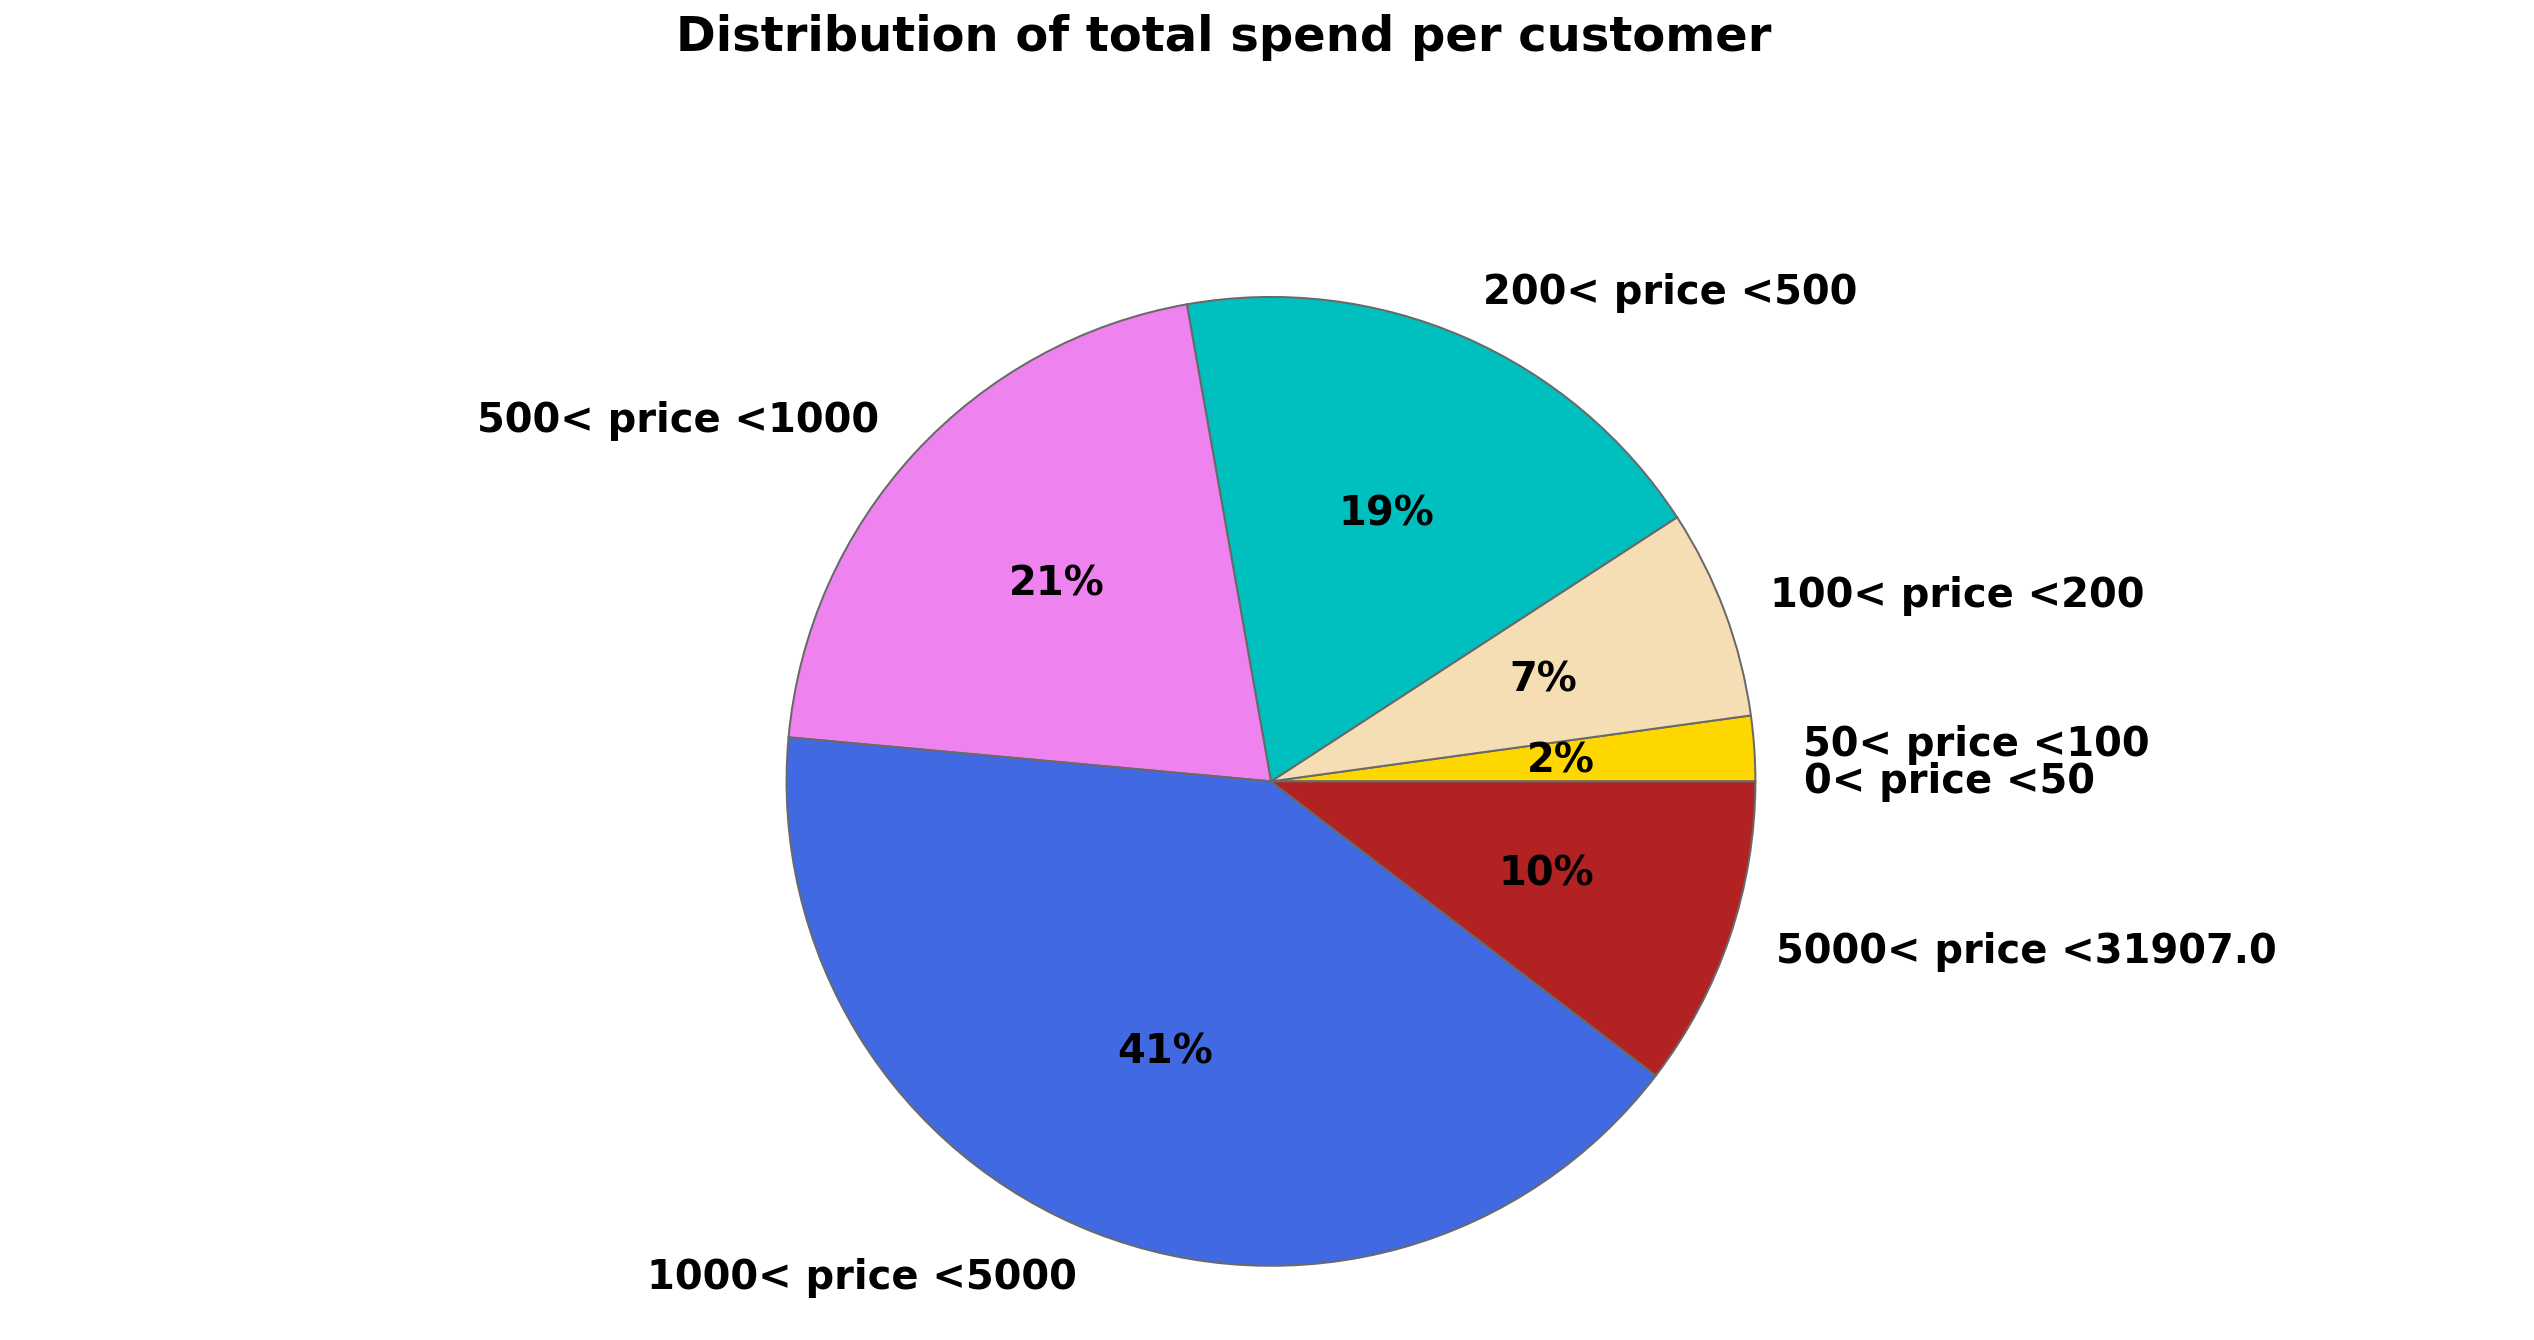

In [52]:
# Customers distribution per total spend
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

#____________________
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, df_out['TotalValue'].max().round(0)]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = df_out[(df_out['TotalValue'] < price) &
                       (df_out['TotalValue'] > price_range[i-1])]['TotalValue'].count()
    count_price.append(val)
#____________________________________________
# Representation of the number of purchases / amount      
#plt.rc('font', weight='bold')
plt.rc('font', **font)

f, ax = plt.subplots(figsize=(20, 10))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}< price <{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of total spend per customer", ha='center', fontsize = 24);

As a conclusion, we can say that most of the customers(41% of total) are spending between [£1000, £5000], which clasify them into medium spenders.

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans



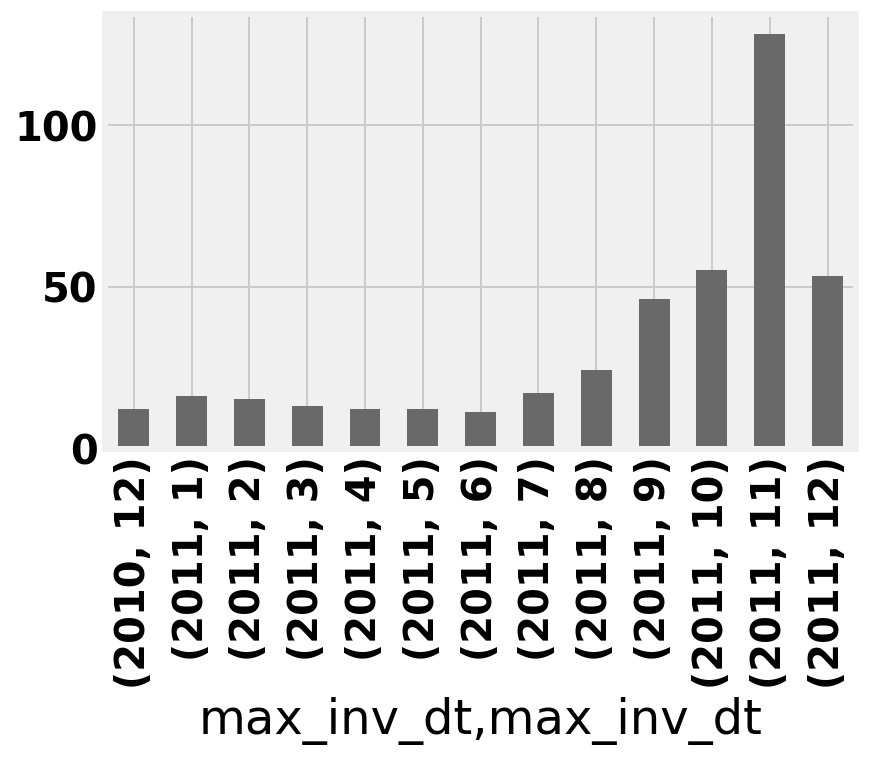

In [53]:
# Customer distribution per date
df_out.groupby([df_out["max_inv_dt"].dt.year, df_out["max_inv_dt"].dt.month]).count().plot(kind="bar",legend=False)

Based on the graph above, we are going to split the customers into active and less active/ we will consider max_inv_dt =Oct2011 as the split date into those two categories.

In [54]:
NOW = dt.datetime(2011,10,1)
print(NOW)
print('')
# create the active/inactive flag in the output table and get dummies after that
def new_cols (df_out):
  if df_out["max_inv_dt"]>=NOW:
    return 1
  elif df_out["max_inv_dt"]<NOW:
    return 0

df_out['is_active']=df_out.apply (lambda df_out: new_cols(df_out),axis=1)
df_out.head()


2011-10-01 00:00:00



CustomerID  TotalValue  min_inv_val  max_inv_val  avg_inv_val min_inv_dt  \
0     12347.0     4310.00        225.0       1294.0        616.0 2010-12-07   
1     12348.0     1797.24        227.0        893.0        449.0 2010-12-16   
2     12349.0     1757.55       1758.0       1758.0       1758.0 2011-11-21   
3     12350.0      334.40        334.0        334.0        334.0 2011-02-02   
4     12352.0     2506.04        120.0        840.0        313.0 2011-02-16   

  max_inv_dt  order_dt_range  total_orders  total_prod_line  \
0 2011-12-07           365.0             7              182   
1 2011-09-25           282.0             4               31   
2 2011-11-21             0.0             1               73   
3 2011-02-02             0.0             1               17   
4 2011-11-03           260.0             8               85   

   avg_prod_line_p_inv  week  wend   BAGS  BAKING  CARRIAGE & POST  CRAFTS  \
0                 26.0     7     0  451.9  402.45              0.0  163.20   
1                  8.0     3     1    0.0  507.60            360.0  301.20   
2                 73.0     1     0    0.0  107.86            300.0   63.03   
3                 17.0     1     0   20.4    0.00             40.0    0.00   
4                 11.0     8     0    0.0  229.95            280.0   74.35   

   GAMES & TOYS  GIFT & PARTY  HOME WARE  JEWELLERY & MAKE-UP  KITCHEN WARE  \
0         510.3          22.8    1451.52               249.60        750.40   
1           0.0          17.0       0.00               611.44          0.00   
2           0.0         120.3     486.50               109.80        372.76   
3          30.0           0.0     156.10                 0.00          0.00   
4          15.0         149.3     244.10                51.60        464.94   

   MANUAL    MISC  OUTDOORS  PHOTO & PICTURES  STATIONERY  STORAGE  \
0     0.0  114.78      29.1              37.5       75.60    50.85   
1     0.0    0.00       0.0               0.0        0.00     0.00   
2     0.0   67.00      57.6               0.0       17.40    55.30   
3     0.0   68.10       0.0               0.0       19.80     0.00   
4   840.3   96.95      29.7               0.0       29.85     0.00   

   Continent_Africa  Continent_Asia  Continent_Australias  Continent_Europe  \
0                 0               0                     0                 1   
1                 0               0                     0                 1   
2                 0               0                     0                 1   
3                 0               0                     0                 1   
4                 0               0                     0                 1   

   Continent_North America  Continent_South America  Continent_Unknown  \
0                        0                        0                  0   
1                        0                        0                  0   
2                        0                        0                  0   
3                        0                        0                  0   
4                        0                        0                  0   

   is_active  
0          1  
1          0  
2          1  
3          0  
4          1

In [55]:
# some other date manipulation
# first try to do split max invoice date into the 3 column as day,month,year

df_out['max_inv_dt_day'] =  df_out['max_inv_dt'].dt.day
df_out['max_inv_dt_month'] =  df_out['max_inv_dt'].dt.month
df_out['max_inv_dt_year'] =  df_out['max_inv_dt'].dt.year

#The other try : concat year-month-day values as integer.

df_out['max_inv_dt_int'] = df_out['max_inv_dt'].astype(int)

df_out.head()

CustomerID  TotalValue  min_inv_val  max_inv_val  avg_inv_val min_inv_dt  \
0     12347.0     4310.00        225.0       1294.0        616.0 2010-12-07   
1     12348.0     1797.24        227.0        893.0        449.0 2010-12-16   
2     12349.0     1757.55       1758.0       1758.0       1758.0 2011-11-21   
3     12350.0      334.40        334.0        334.0        334.0 2011-02-02   
4     12352.0     2506.04        120.0        840.0        313.0 2011-02-16   

  max_inv_dt  order_dt_range  total_orders  total_prod_line  \
0 2011-12-07           365.0             7              182   
1 2011-09-25           282.0             4               31   
2 2011-11-21             0.0             1               73   
3 2011-02-02             0.0             1               17   
4 2011-11-03           260.0             8               85   

   avg_prod_line_p_inv  week  wend   BAGS  BAKING  CARRIAGE & POST  CRAFTS  \
0                 26.0     7     0  451.9  402.45              0.0  163.20   
1                  8.0     3     1    0.0  507.60            360.0  301.20   
2                 73.0     1     0    0.0  107.86            300.0   63.03   
3                 17.0     1     0   20.4    0.00             40.0    0.00   
4                 11.0     8     0    0.0  229.95            280.0   74.35   

   GAMES & TOYS  GIFT & PARTY  HOME WARE  JEWELLERY & MAKE-UP  KITCHEN WARE  \
0         510.3          22.8    1451.52               249.60        750.40   
1           0.0          17.0       0.00               611.44          0.00   
2           0.0         120.3     486.50               109.80        372.76   
3          30.0           0.0     156.10                 0.00          0.00   
4          15.0         149.3     244.10                51.60        464.94   

   MANUAL    MISC  OUTDOORS  PHOTO & PICTURES  STATIONERY  STORAGE  \
0     0.0  114.78      29.1              37.5       75.60    50.85   
1     0.0    0.00       0.0               0.0        0.00     0.00   
2     0.0   67.00      57.6               0.0       17.40    55.30   
3     0.0   68.10       0.0               0.0       19.80     0.00   
4   840.3   96.95      29.7               0.0       29.85     0.00   

   Continent_Africa  Continent_Asia  Continent_Australias  Continent_Europe  \
0                 0               0                     0                 1   
1                 0               0                     0                 1   
2                 0               0                     0                 1   
3                 0               0                     0                 1   
4                 0               0                     0                 1   

   Continent_North America  Continent_South America  Continent_Unknown  \
0                        0                        0                  0   
1                        0                        0                  0   
2                        0                        0                  0   
3                        0                        0                  0   
4                        0                        0                  0   

   is_active  max_inv_dt_day  max_inv_dt_month  max_inv_dt_year  \
0          1               7                12             2011   
1          0              25                 9             2011   
2          1              21                11             2011   
3          0               2                 2             2011   
4          1               3                11             2011   

        max_inv_dt_int  
0  1323216000000000000  
1  1316908800000000000  
2  1321833600000000000  
3  1296604800000000000  
4  1320278400000000000

In [56]:
print(df_out.columns)

print(df_out.shape)

Index(['CustomerID', 'TotalValue', 'min_inv_val', 'max_inv_val', 'avg_inv_val',
       'min_inv_dt', 'max_inv_dt', 'order_dt_range', 'total_orders',
       'total_prod_line', 'avg_prod_line_p_inv', 'week', 'wend', 'BAGS',
       'BAKING', 'CARRIAGE & POST', 'CRAFTS', 'GAMES & TOYS', 'GIFT & PARTY',
       'HOME WARE', 'JEWELLERY & MAKE-UP', 'KITCHEN WARE', 'MANUAL', 'MISC',
       'OUTDOORS', 'PHOTO & PICTURES', 'STATIONERY', 'STORAGE',
       'Continent_Africa', 'Continent_Asia', 'Continent_Australias',
       'Continent_Europe', 'Continent_North America',
       'Continent_South America', 'Continent_Unknown', 'is_active',
       'max_inv_dt_day', 'max_inv_dt_month', 'max_inv_dt_year',
       'max_inv_dt_int'],
      dtype='object')
(414, 40)


The final dataframe has 34 variables and 414 entries.
As a next step, we are going to create a new dataframe that will be used to fit the models.

## 2. Feature Relevance

Is any of the features actually relevant for understanding customer purchasing?

---

Using a loop to predicted every single feature as a dependent variable :

In [57]:
# create a copy of the final output table
df_result=df_out[[
       #'CustomerID', 
       'TotalValue', 
       'min_inv_val', 'max_inv_val', 
       'avg_inv_val',
       #'min_inv_dt', 'max_inv_dt',
       'order_dt_range', 'total_orders',
       'total_prod_line', 'avg_prod_line_p_inv', 
       'week',
       'wend', 'BAGS',
       'BAKING', 'CARRIAGE & POST', 
       'CRAFTS', # high correlated (positive) with Games&Toys, Baking
       'GAMES & TOYS', 'GIFT & PARTY',
       'HOME WARE', 'JEWELLERY & MAKE-UP', 'KITCHEN WARE', 'MANUAL', 'MISC',
       'OUTDOORS', 'PHOTO & PICTURES', 'STATIONERY', 'STORAGE',
       'Continent_Africa', 'Continent_Asia', 'Continent_Australias',
       'Continent_Europe', 'Continent_North America',
       'Continent_South America', 'Continent_Unknown', 'is_active',
       'max_inv_dt_day', 'max_inv_dt_month', 'max_inv_dt_year', 'max_inv_dt_int'
                 ]].copy()


**Check Feature Importance using Random Forests**

---

Which of our features have most variance and which has least?
For this we are going to use the Random Forest, which will help us to identify if Baking(for example) is going to contribute to our prediction.

In [59]:
df_result.head()

TotalValue  min_inv_val  max_inv_val  avg_inv_val  order_dt_range  \
0     4310.00        225.0       1294.0        616.0           365.0   
1     1797.24        227.0        893.0        449.0           282.0   
2     1757.55       1758.0       1758.0       1758.0             0.0   
3      334.40        334.0        334.0        334.0             0.0   
4     2506.04        120.0        840.0        313.0           260.0   

   total_orders  total_prod_line  avg_prod_line_p_inv  week  wend   BAGS  \
0             7              182                 26.0     7     0  451.9   
1             4               31                  8.0     3     1    0.0   
2             1               73                 73.0     1     0    0.0   
3             1               17                 17.0     1     0   20.4   
4             8               85                 11.0     8     0    0.0   

   BAKING  CARRIAGE & POST  CRAFTS  GAMES & TOYS  GIFT & PARTY  HOME WARE  \
0  402.45              0.0  163.20         510.3          22.8    1451.52   
1  507.60            360.0  301.20           0.0          17.0       0.00   
2  107.86            300.0   63.03           0.0         120.3     486.50   
3    0.00             40.0    0.00          30.0           0.0     156.10   
4  229.95            280.0   74.35          15.0         149.3     244.10   

   JEWELLERY & MAKE-UP  KITCHEN WARE  MANUAL    MISC  OUTDOORS  \
0               249.60        750.40     0.0  114.78      29.1   
1               611.44          0.00     0.0    0.00       0.0   
2               109.80        372.76     0.0   67.00      57.6   
3                 0.00          0.00     0.0   68.10       0.0   
4                51.60        464.94   840.3   96.95      29.7   

   PHOTO & PICTURES  STATIONERY  STORAGE  Continent_Africa  Continent_Asia  \
0              37.5       75.60    50.85                 0               0   
1               0.0        0.00     0.00                 0               0   
2               0.0       17.40    55.30                 0               0   
3               0.0       19.80     0.00                 0               0   
4               0.0       29.85     0.00                 0               0   

   Continent_Australias  Continent_Europe  Continent_North America  \
0                     0                 1                        0   
1                     0                 1                        0   
2                     0                 1                        0   
3                     0                 1                        0   
4                     0                 1                        0   

   Continent_South America  Continent_Unknown  is_active  max_inv_dt_day  \
0                        0                  0          1               7   
1                        0                  0          0              25   
2                        0                  0          1              21   
3                        0                  0          0               2   
4                        0                  0          1               3   

   max_inv_dt_month  max_inv_dt_year       max_inv_dt_int  
0                12             2011  1323216000000000000  
1                 9             2011  1316908800000000000  
2                11             2011  1321833600000000000  
3                 2             2011  1296604800000000000  
4                11             2011  1320278400000000000

In [60]:
# Create input and target variables
X = df_result.drop(['is_active'], axis = 1)
y = df_result['is_active'].copy()


In [61]:
# Create input and target variables, when trying to predict which customers is active or not
X = df_result.drop(['is_active'], axis = 1)
y = df_result['is_active'].copy()
features = X.columns
# Import Random forest library
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

# Fitting RF on the dataset
rf.fit(X, y)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [62]:
# Using sklearn's feature_importances_ object, let us see which columns exhibit the most variance and contribute
# towards the model's performance. We will sort it in descending order to see the most important features first
feature_importances = rf.feature_importances_
indices = np.argsort(feature_importances)

# print the list
#print (['{}: {:.2f}'.format(feature, importance) for feature, importance in zip(features[indices], feature_importances[indices])][::-1])

pd.DataFrame(list(zip(feature_importances[indices])),index=features[indices], columns=['importance']).sort_values('importance', ascending=False)

importance
max_inv_dt_month           0.366906
max_inv_dt_int             0.293132
week                       0.055994
HOME WARE                  0.037118
total_orders               0.026746
total_prod_line            0.026240
max_inv_dt_year            0.025274
order_dt_range             0.024222
MISC                       0.017286
TotalValue                 0.012820
GIFT & PARTY               0.012266
BAKING                     0.012190
avg_prod_line_p_inv        0.012006
GAMES & TOYS               0.010190
JEWELLERY & MAKE-UP        0.009593
avg_inv_val                0.009298
KITCHEN WARE               0.007987
max_inv_dt_day             0.007429
CRAFTS                     0.006525
BAGS                       0.004906
STORAGE                    0.004054
min_inv_val                0.003328
CARRIAGE & POST            0.003161
max_inv_val                0.002543
Continent_Europe           0.002354
PHOTO & PICTURES           0.002238
wend                       0.001760
Continent_Australias       0.001609
OUTDOORS                   0.000826
Continent_Asia             0.000000
Continent_Unknown          0.000000
Continent_South America    0.000000
STATIONERY                 0.000000
Continent_North America    0.000000
MANUAL                     0.000000
Continent_Africa           0.000000

Now let's use a bar graph to vizualize how significant are the top variables.

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans



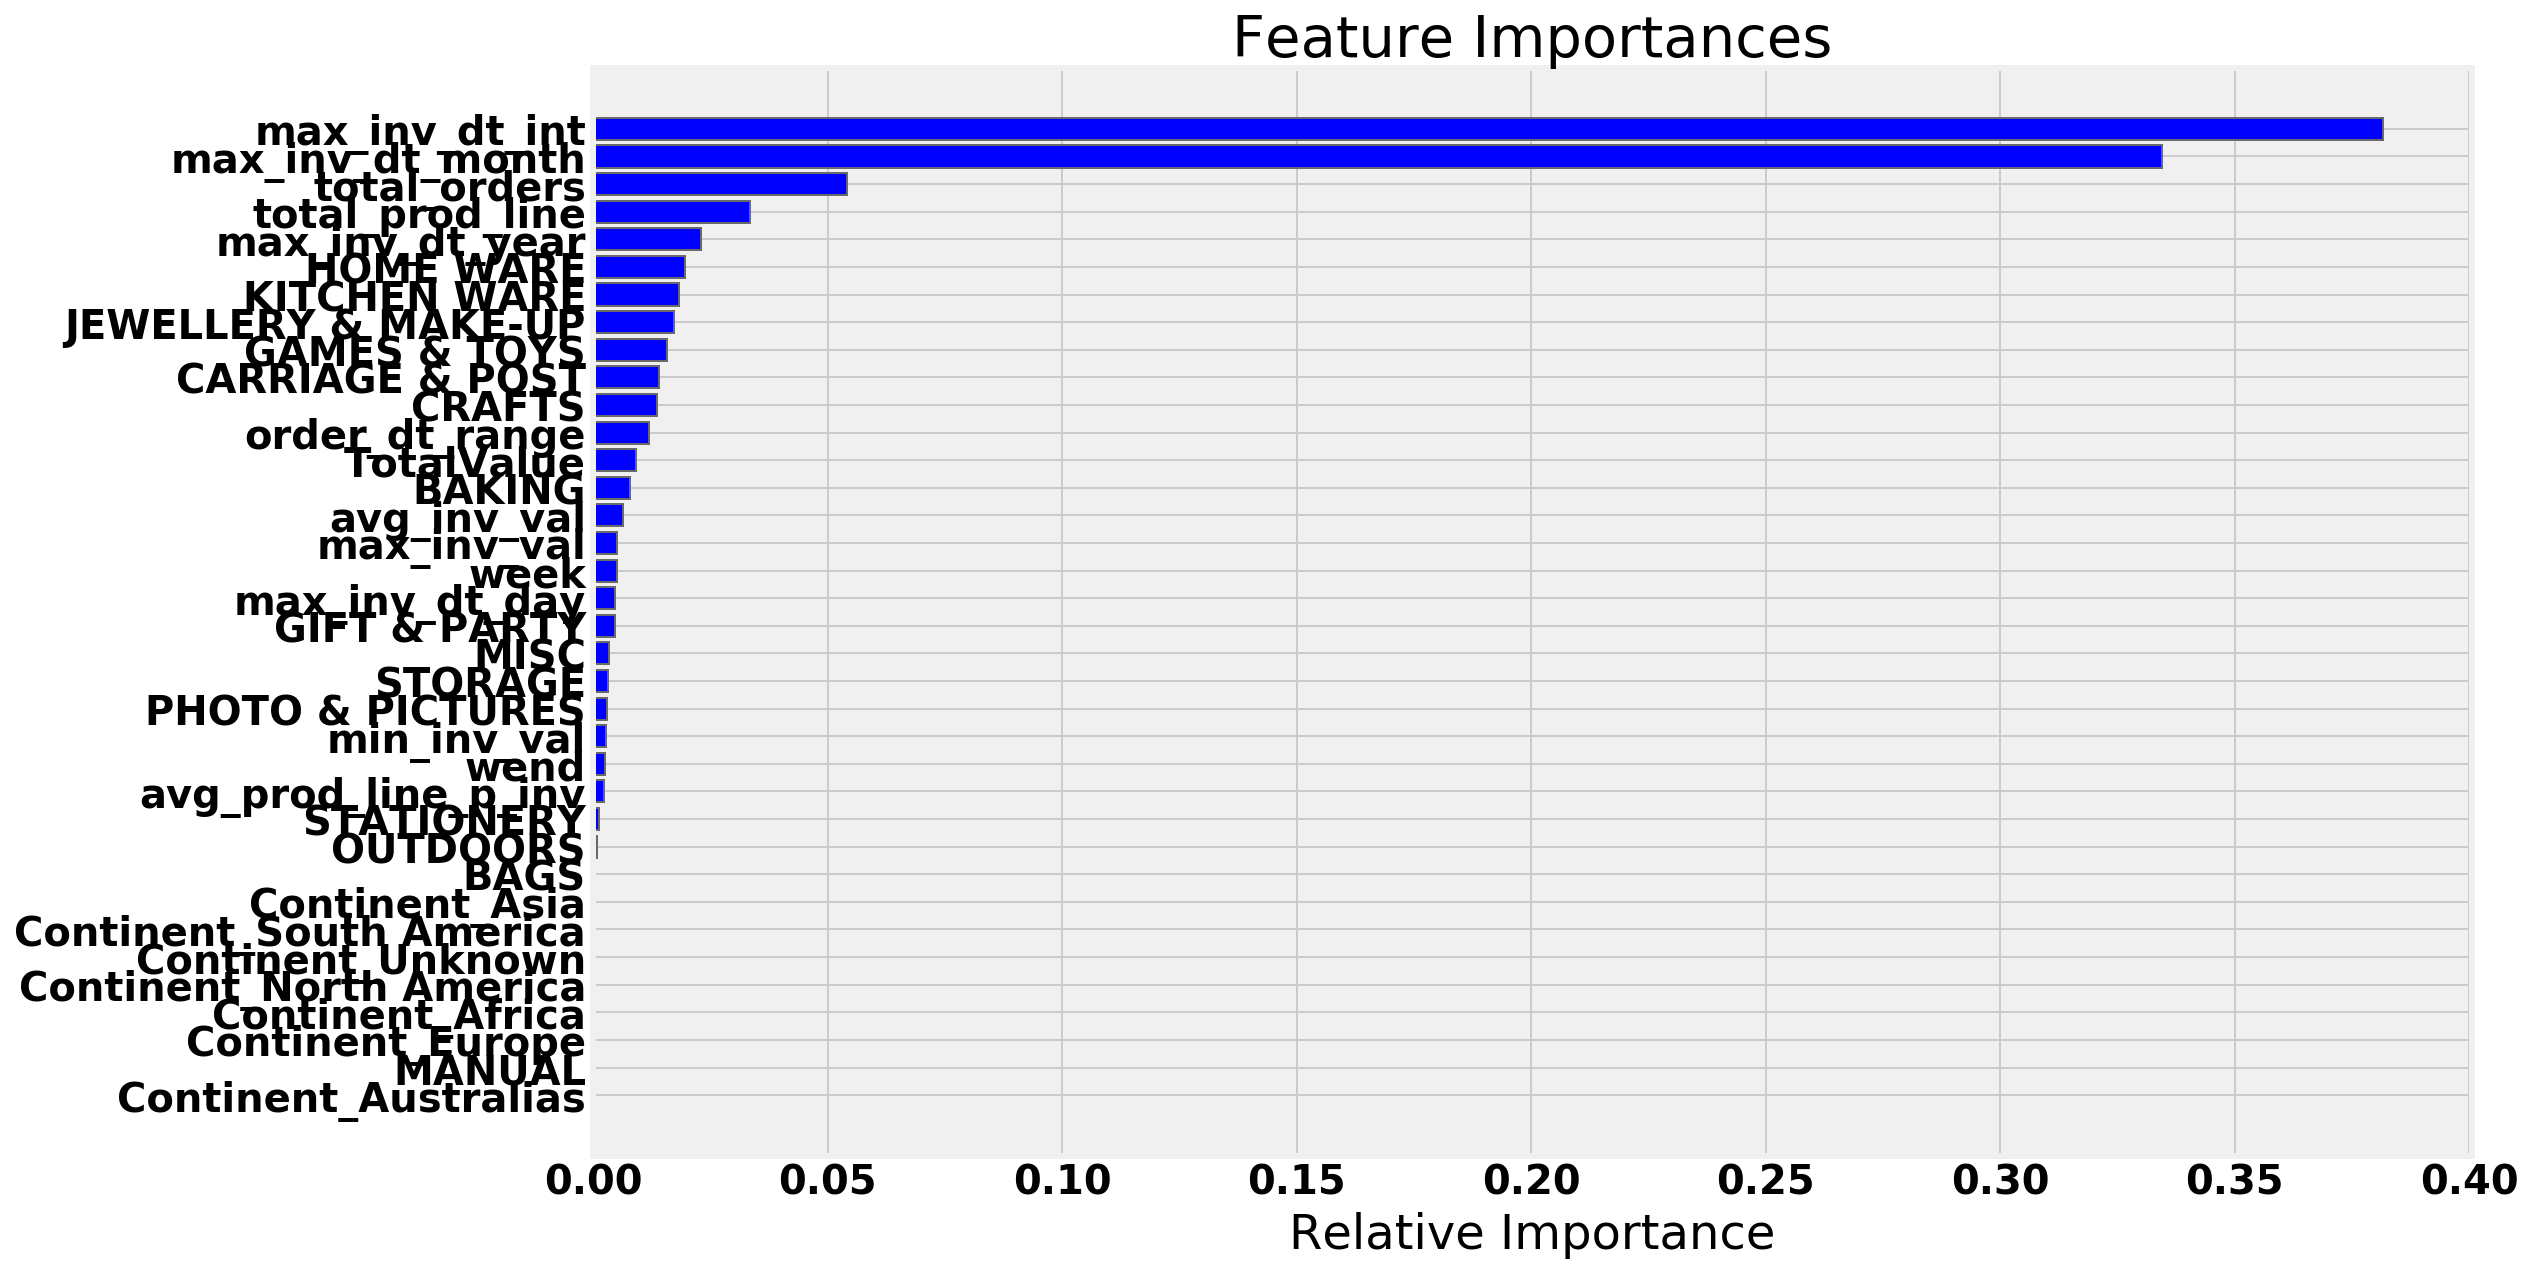

In [34]:
figure, ax = plt.subplots(figsize=(15, 10))
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance');



As we can see, the most important one is max_inv_dt_day and the least important ones are the continents and max_inv_dt_year.
Now that we know the importance of each variables, let's drop the insignificant ones and then check the relevance between the rest.

In [63]:
df_out.head()

CustomerID  TotalValue  min_inv_val  max_inv_val  avg_inv_val min_inv_dt  \
0     12347.0     4310.00        225.0       1294.0        616.0 2010-12-07   
1     12348.0     1797.24        227.0        893.0        449.0 2010-12-16   
2     12349.0     1757.55       1758.0       1758.0       1758.0 2011-11-21   
3     12350.0      334.40        334.0        334.0        334.0 2011-02-02   
4     12352.0     2506.04        120.0        840.0        313.0 2011-02-16   

  max_inv_dt  order_dt_range  total_orders  total_prod_line  \
0 2011-12-07           365.0             7              182   
1 2011-09-25           282.0             4               31   
2 2011-11-21             0.0             1               73   
3 2011-02-02             0.0             1               17   
4 2011-11-03           260.0             8               85   

   avg_prod_line_p_inv  week  wend   BAGS  BAKING  CARRIAGE & POST  CRAFTS  \
0                 26.0     7     0  451.9  402.45              0.0  163.20   
1                  8.0     3     1    0.0  507.60            360.0  301.20   
2                 73.0     1     0    0.0  107.86            300.0   63.03   
3                 17.0     1     0   20.4    0.00             40.0    0.00   
4                 11.0     8     0    0.0  229.95            280.0   74.35   

   GAMES & TOYS  GIFT & PARTY  HOME WARE  JEWELLERY & MAKE-UP  KITCHEN WARE  \
0         510.3          22.8    1451.52               249.60        750.40   
1           0.0          17.0       0.00               611.44          0.00   
2           0.0         120.3     486.50               109.80        372.76   
3          30.0           0.0     156.10                 0.00          0.00   
4          15.0         149.3     244.10                51.60        464.94   

   MANUAL    MISC  OUTDOORS  PHOTO & PICTURES  STATIONERY  STORAGE  \
0     0.0  114.78      29.1              37.5       75.60    50.85   
1     0.0    0.00       0.0               0.0        0.00     0.00   
2     0.0   67.00      57.6               0.0       17.40    55.30   
3     0.0   68.10       0.0               0.0       19.80     0.00   
4   840.3   96.95      29.7               0.0       29.85     0.00   

   Continent_Africa  Continent_Asia  Continent_Australias  Continent_Europe  \
0                 0               0                     0                 1   
1                 0               0                     0                 1   
2                 0               0                     0                 1   
3                 0               0                     0                 1   
4                 0               0                     0                 1   

   Continent_North America  Continent_South America  Continent_Unknown  \
0                        0                        0                  0   
1                        0                        0                  0   
2                        0                        0                  0   
3                        0                        0                  0   
4                        0                        0                  0   

   is_active  max_inv_dt_day  max_inv_dt_month  max_inv_dt_year  \
0          1               7                12             2011   
1          0              25                 9             2011   
2          1              21                11             2011   
3          0               2                 2             2011   
4          1               3                11             2011   

        max_inv_dt_int  
0  1323216000000000000  
1  1316908800000000000  
2  1321833600000000000  
3  1296604800000000000  
4  1320278400000000000

In [64]:
# create a copy of the final output table
df_result=df_out[[
       #'CustomerID', 
       'TotalValue', 
       #'min_inv_val', 'max_inv_val', 
       #'avg_inv_val',
       #'min_inv_dt', 'max_inv_dt',
       #'order_dt_range', 
       'total_orders',
       #'total_prod_line', 'avg_prod_line_p_inv', 
       #'week','wend',
       'BAGS',
       'BAKING',
       #'CARRIAGE & POST', 
       #'CRAFTS', # high correlated (positive) with Games&Toys, Baking
       'GAMES & TOYS', 
       'GIFT & PARTY',
       #'HOME WARE', 
       'JEWELLERY & MAKE-UP',
       #'KITCHEN WARE',
       #'MANUAL',
       'MISC',
       'OUTDOORS', 
       'PHOTO & PICTURES', 
       'STATIONERY', 
       'STORAGE',
       #'Continent_Africa', 'Continent_Asia', 'Continent_Australias',
       #'Continent_Europe', 'Continent_North America',
       #'Continent_South America', 'Continent_Unknown', 
       'is_active',
       #'max_inv_dt_day', 'max_inv_dt_month', 
       #'max_inv_dt_year', 
       'max_inv_dt_int'
                 ]].copy()


Are all variables relevant to understand customers' behaviour? For this we will have a look first at R^2 for each of the variable.
The coefficient of determination, R^2, is scored between 0 and 1, with 1 being a perfect fit. A negative R^2 implies the model fails to fit the data.



In [65]:
from sklearn.tree import DecisionTreeRegressor
from operator import itemgetter

# Create list to loop through
dep_vars = list(df_result.columns)

score_array =[]

# Create loop to test each feature as a dependent variable
for var in dep_vars:
  # TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
  new_data = df_result.drop([var], axis = 1)
  # Create feature Series (Vector)
  new_feature = pd.DataFrame(df_result.loc[:, var])

  # TODO: Split the data into training and testing sets using the given feature as the target
  X_train, X_test, y_train, y_test = train_test_split(new_data, new_feature, test_size=0.25, random_state=42)

  # TODO: Create a decision tree regressor and fit it to the training set
  # Instantiate
  dtr = DecisionTreeRegressor(random_state=42,presort=True)
  # Fit
  dtr.fit(X_train, y_train)

  # TODO: Report the score of the prediction using the testing set
  # Returns R^2
  score = round(dtr.score(X_test, y_test),2)
  score_array.append([var,score])
  
print('R2 score for dependent variable: \n')
score_array = sorted(score_array,key=itemgetter(1),reverse=True)
score_df=pd.DataFrame(score_array)
score_df.columns=['Features','Score']
score_df

R2 score for dependent variable: 



Features  Score
0             is_active   1.00
1            TotalValue   0.48
2          total_orders   0.46
3        max_inv_dt_int   0.36
4               STORAGE   0.05
5            STATIONERY  -0.46
6              OUTDOORS  -0.47
7                  BAGS  -0.51
8                  MISC  -0.77
9          GIFT & PARTY  -1.21
10     PHOTO & PICTURES  -1.83
11  JEWELLERY & MAKE-UP  -2.68
12         GAMES & TOYS  -2.78
13               BAKING -11.50

This high R^2 value means that the feature is significantly explained by the other features in the data, meaning that it is not necessary for identifying customers' spending habits.

In conclusion, we can remove those variables that have a high correlation with other, and keep only one of them.
To get a better understanding of the dataframe, we can construct a scatter matrix and correlation table:

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans



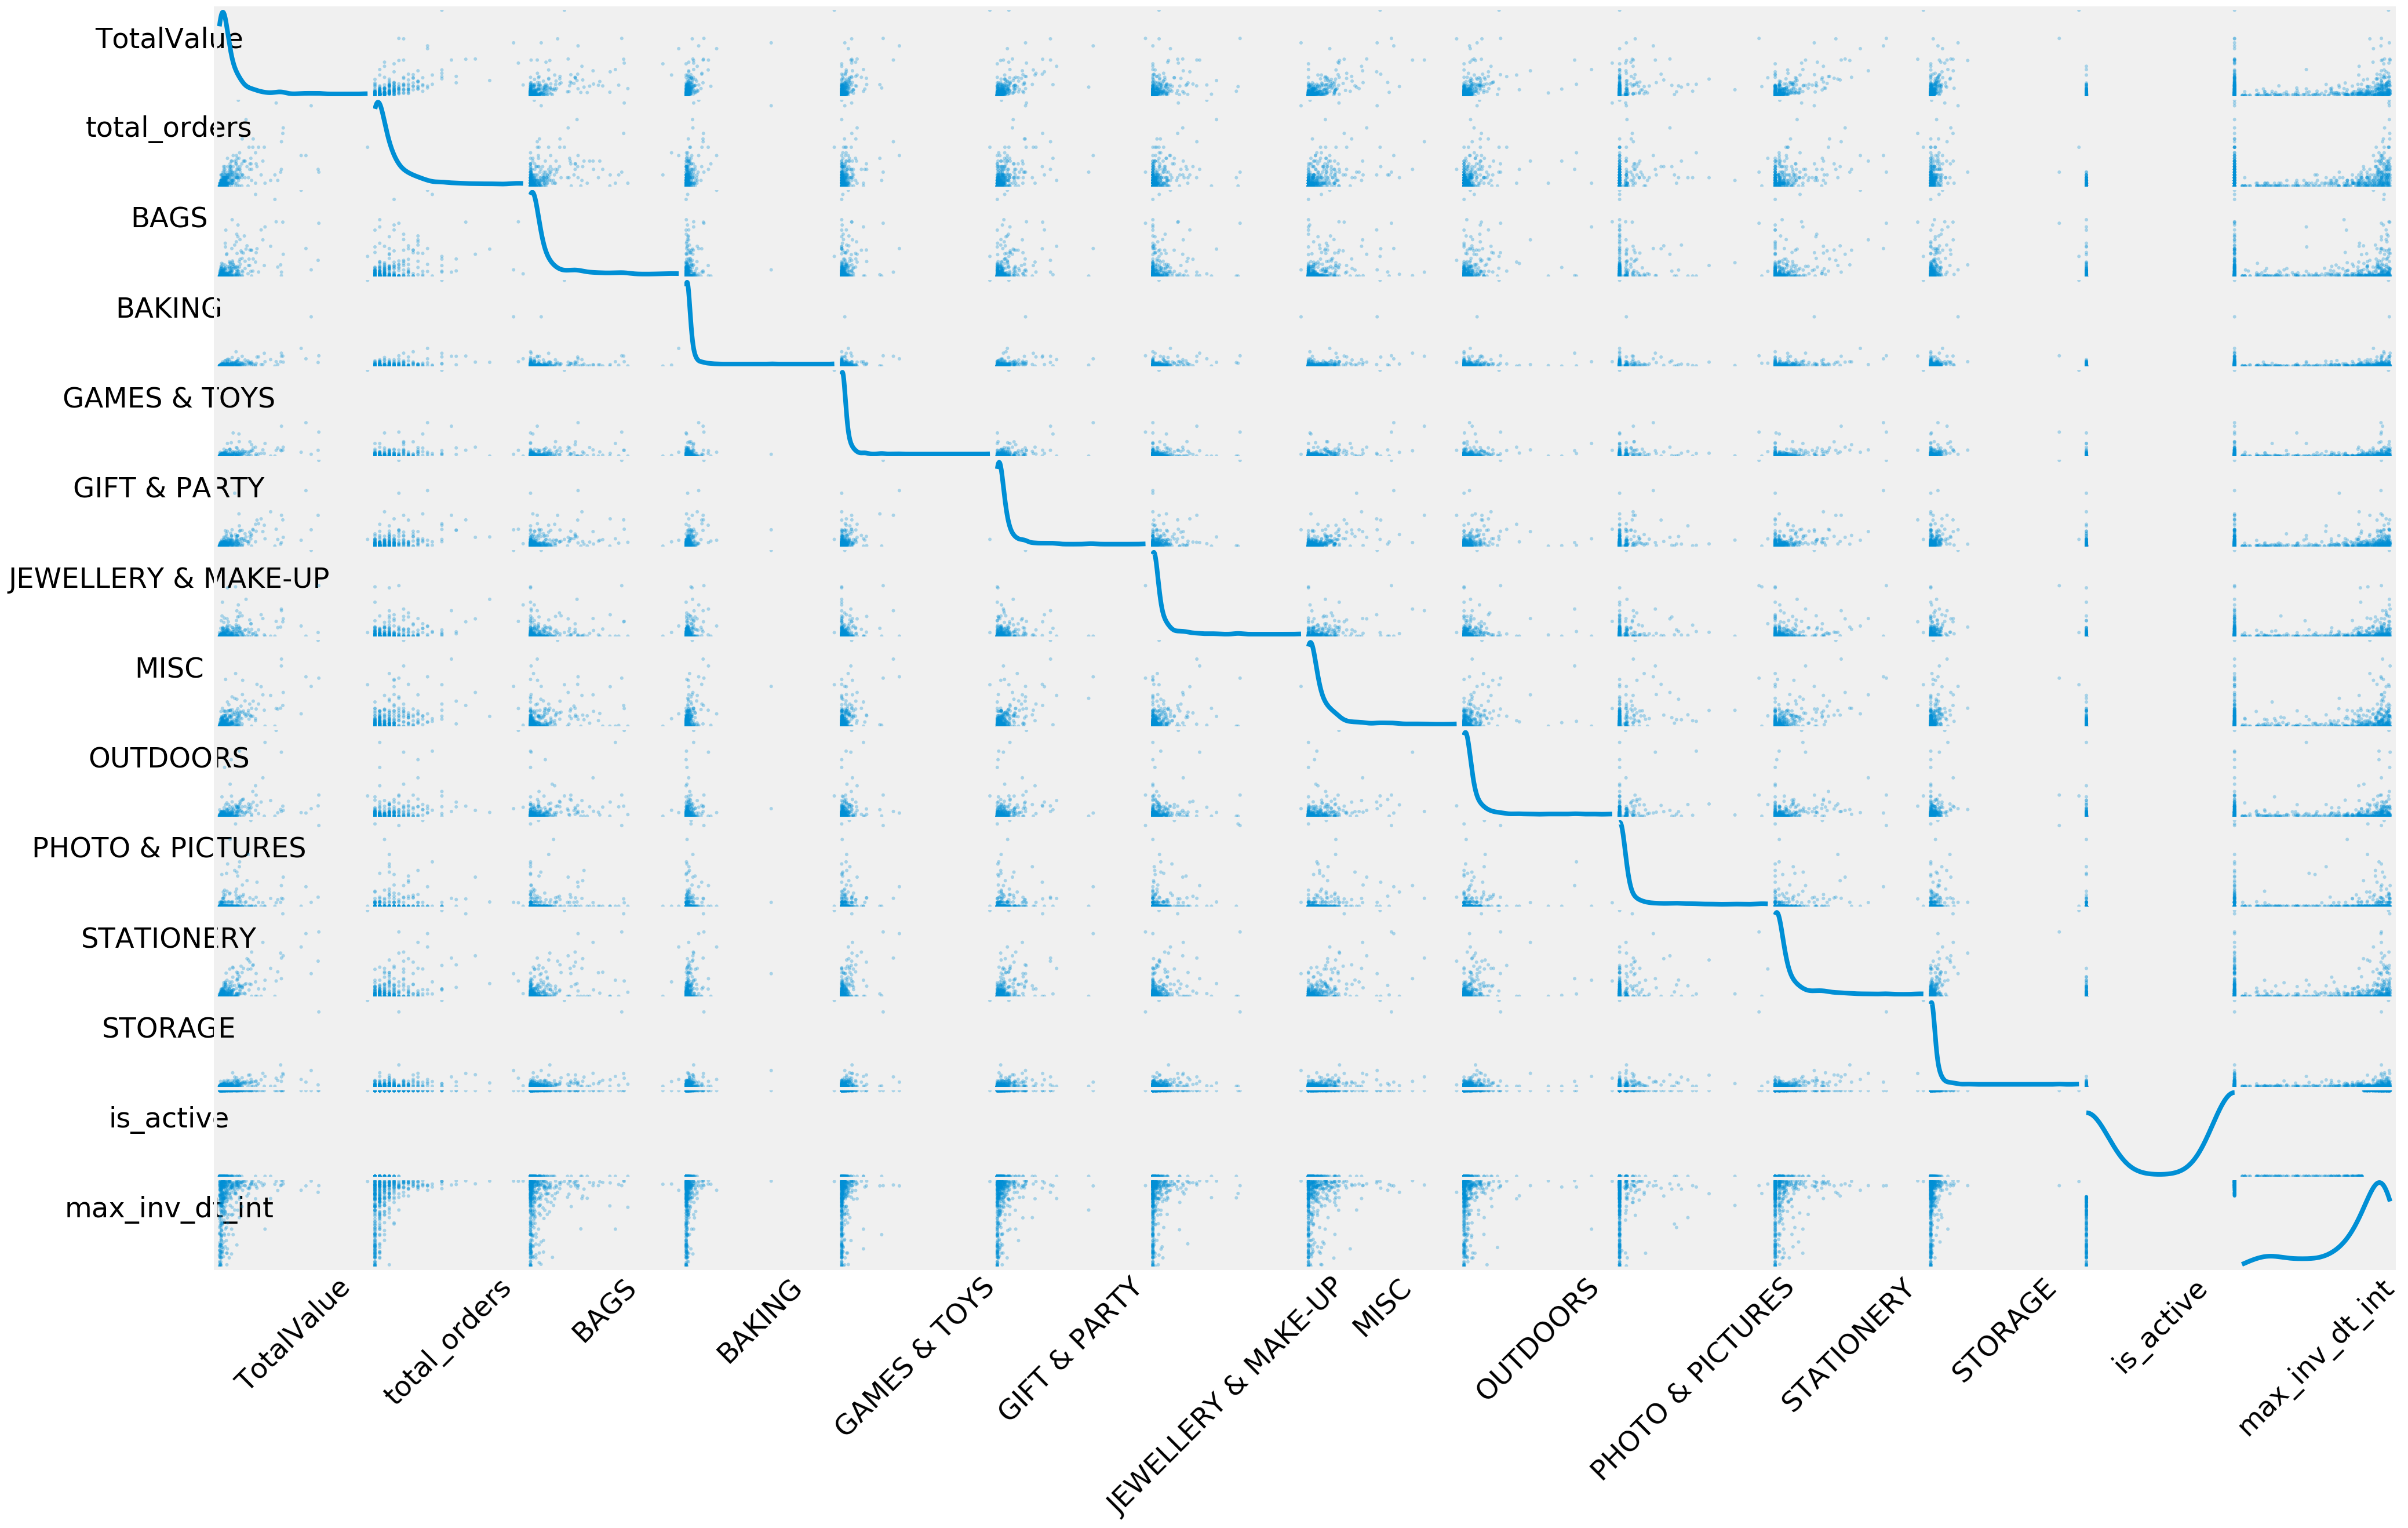

In [66]:
# Feature Distributions
# Produce a scatter matrix for each pair of features in the data
sm = pd.scatter_matrix(df_result, alpha = 0.3, figsize = (30,20), diagonal = 'kde');

#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

There are a couple of pairs that show some degree of correlation, such as 'week' and 'total_orders' or 'avg_inv_val' and 'max_inv_val'.
The distribution all appears to be skewed, with the right tail being very long.

As a double check for our pairs, we are going to run the correlation between variables and to plot the result with a heatmap.

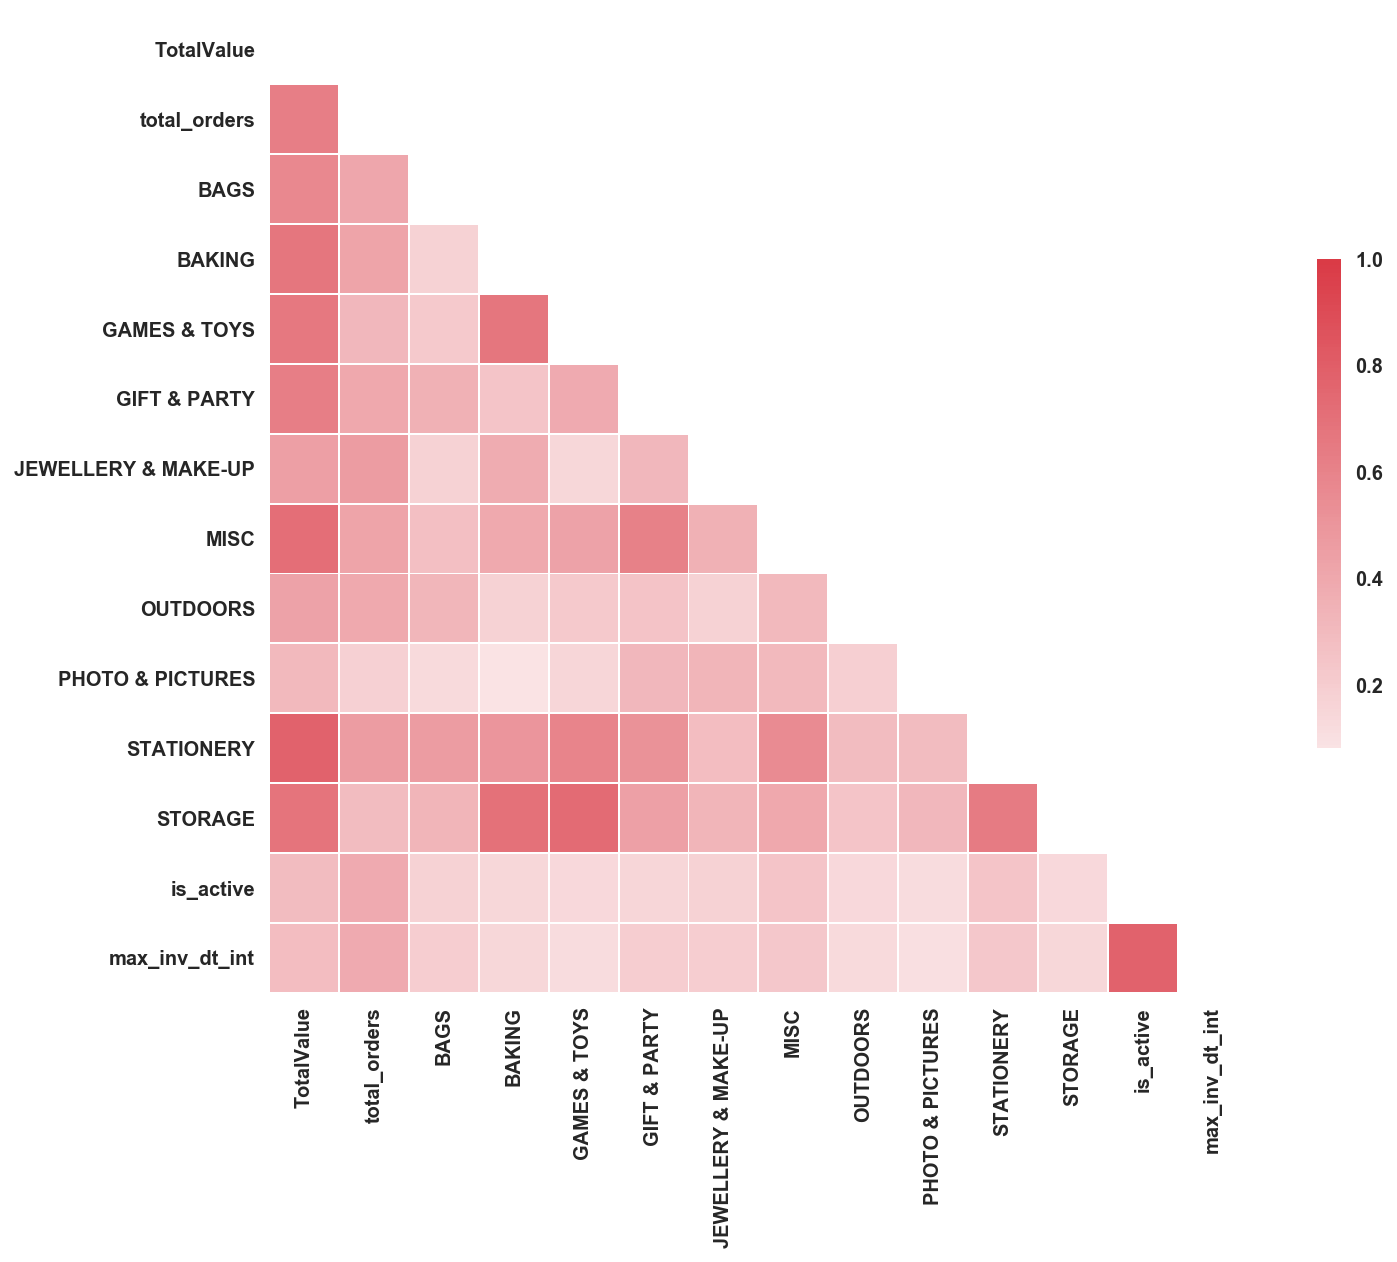

In [67]:
# Create the correlation graph

sns.set(style="white")

# Compute the correlation matrix
corr = df_result.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Both the heatmap and the table below, show that there is a high correlation between:
 - TotalValue and Home Ware (0.83) , 
 - craft and baking (0.78), 
 - games&toys and craft (0.82)

In [68]:
df_result.corr()

TotalValue  total_orders      BAGS    BAKING  \
TotalValue             1.000000      0.628466  0.572420  0.680385   
total_orders           0.628466      1.000000  0.411092  0.429827   
BAGS                   0.572420      0.411092  1.000000  0.174557   
BAKING                 0.680385      0.429827  0.174557  1.000000   
GAMES & TOYS           0.658162      0.315054  0.222836  0.680556   
GIFT & PARTY           0.629002      0.397944  0.351830  0.250158   
JEWELLERY & MAKE-UP    0.449707      0.466510  0.176246  0.378279   
MISC                   0.711360      0.425164  0.277221  0.395168   
OUTDOORS               0.433860      0.396572  0.327977  0.174943   
PHOTO & PICTURES       0.311245      0.185121  0.135090  0.082134   
STATIONERY             0.781179      0.467041  0.464532  0.502354   
STORAGE                0.681125      0.290800  0.331313  0.698056   
is_active              0.291170      0.388458  0.174979  0.145688   
max_inv_dt_int         0.285940      0.383601  0.197949  0.149281   

                     GAMES & TOYS  GIFT & PARTY  JEWELLERY & MAKE-UP  \
TotalValue               0.658162      0.629002             0.449707   
total_orders             0.315054      0.397944             0.466510   
BAGS                     0.222836      0.351830             0.176246   
BAKING                   0.680556      0.250158             0.378279   
GAMES & TOYS             1.000000      0.385427             0.143698   
GIFT & PARTY             0.385427      1.000000             0.311864   
JEWELLERY & MAKE-UP      0.143698      0.311864             1.000000   
MISC                     0.434834      0.611682             0.356331   
OUTDOORS                 0.223246      0.253985             0.174818   
PHOTO & PICTURES         0.151526      0.320514             0.330140   
STATIONERY               0.596904      0.519854             0.283693   
STORAGE                  0.731666      0.442468             0.335918   
is_active                0.138420      0.154889             0.176990   
max_inv_dt_int           0.123109      0.199355             0.197129   

                         MISC  OUTDOORS  PHOTO & PICTURES  STATIONERY  \
TotalValue           0.711360  0.433860          0.311245    0.781179   
total_orders         0.425164  0.396572          0.185121    0.467041   
BAGS                 0.277221  0.327977          0.135090    0.464532   
BAKING               0.395168  0.174943          0.082134    0.502354   
GAMES & TOYS         0.434834  0.223246          0.151526    0.596904   
GIFT & PARTY         0.611682  0.253985          0.320514    0.519854   
JEWELLERY & MAKE-UP  0.356331  0.174818          0.330140    0.283693   
MISC                 1.000000  0.305371          0.310074    0.556066   
OUTDOORS             0.305371  1.000000          0.194077    0.296537   
PHOTO & PICTURES     0.310074  0.194077          1.000000    0.292530   
STATIONERY           0.556066  0.296537          0.292530    1.000000   
STORAGE              0.406533  0.245153          0.314819    0.647598   
is_active            0.244203  0.142470          0.122767    0.249710   
max_inv_dt_int       0.234014  0.133707          0.109830    0.233235   

                      STORAGE  is_active  max_inv_dt_int  
TotalValue           0.681125   0.291170        0.285940  
total_orders         0.290800   0.388458        0.383601  
BAGS                 0.331313   0.174979        0.197949  
BAKING               0.698056   0.145688        0.149281  
GAMES & TOYS         0.731666   0.138420        0.123109  
GIFT & PARTY         0.442468   0.154889        0.199355  
JEWELLERY & MAKE-UP  0.335918   0.176990        0.197129  
MISC                 0.406533   0.244203        0.234014  
OUTDOORS             0.245153   0.142470        0.133707  
PHOTO & PICTURES     0.314819   0.122767        0.109830  
STATIONERY           0.647598   0.249710        0.233235  
STORAGE              1.000000   0.138250        0.143499  
is_active            0.138250   1.000000 

**For the moment, we are not goint to remove any feature, but we are goint to Scale the data, identify/remove the outliers and use PCA to fit the model.**

Scale the data using **StandardScaler**

In [69]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [70]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [71]:
# check the shape of the array
array_df_std = StandardScaler().fit_transform(df_result)
array_df_std.shape

(414, 14)

In [72]:
# use the columns from df_result to create df based on columns name and values in array generated by the StandardScaler
df_result.columns

Index(['TotalValue', 'total_orders', 'BAGS', 'BAKING', 'GAMES & TOYS',
       'GIFT & PARTY', 'JEWELLERY & MAKE-UP', 'MISC', 'OUTDOORS',
       'PHOTO & PICTURES', 'STATIONERY', 'STORAGE', 'is_active',
       'max_inv_dt_int'],
      dtype='object')

In [74]:
# convert array into dataframe
df_std=pd.DataFrame(array_df_std)
df_std.columns = df_result.columns
df_std.head()

TotalValue  total_orders      BAGS    BAKING  GAMES & TOYS  GIFT & PARTY  \
0    0.590486      0.774014  0.740755  0.219295      2.321450     -0.427366   
1   -0.133426      0.068195 -0.480769  0.355220     -0.315424     -0.442998   
2   -0.144860     -0.637624 -0.480769 -0.161515     -0.315424     -0.164583   
3   -0.554861     -0.637624 -0.425626 -0.300943     -0.160405     -0.488817   
4    0.070776      1.009287 -0.480769 -0.003692     -0.237914     -0.086422   

   JEWELLERY & MAKE-UP      MISC  OUTDOORS  PHOTO & PICTURES  STATIONERY  \
0             2.129393  0.458826 -0.197596          0.540389    0.440064   
1             5.814345 -0.557805 -0.396874         -0.294099   -0.481381   
2             0.705681  0.035628 -0.002427         -0.294099   -0.269302   
3            -0.412514  0.045371 -0.396874         -0.294099   -0.240050   
4             0.112976  0.300902 -0.193488         -0.294099   -0.117556   

    STORAGE  is_active  max_inv_dt_int  
0  0.056238   0.868468        0.898280  
1 -0.272691  -1.151452        0.199710  
2  0.085023   0.868468        0.745168  
3 -0.272691  -1.151452       -2.049109  
4 -0.272691   0.868468        0.572918

**Identify Outliers** and remove them if the case, since the presence of them can skew our results. We will use Tukey's Method for identfying outliers: An outlier step is calculated as 1.5 times the interquartile range (IQR)

In [75]:
###### For each feature find the data points with extreme high or low values
for feature in df_std.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df_std[feature], 10)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df_std[feature], 99)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1)*1.5
    
    # Display the outliers
    print ("Data points considered outliers for the feature '{}':".format(feature))
    display(df_std[~((df_std[feature] >= Q1 - step) & (df_std[feature] <= Q3 + step))])
    
    
  


Data points considered outliers for the feature 'TotalValue':


Empty DataFrame
Columns: [TotalValue, total_orders, BAGS, BAKING, GAMES & TOYS, GIFT & PARTY, JEWELLERY & MAKE-UP, MISC, OUTDOORS, PHOTO & PICTURES, STATIONERY, STORAGE, is_active, max_inv_dt_int]
Index: []

Data points considered outliers for the feature 'total_orders':


Empty DataFrame
Columns: [TotalValue, total_orders, BAGS, BAKING, GAMES & TOYS, GIFT & PARTY, JEWELLERY & MAKE-UP, MISC, OUTDOORS, PHOTO & PICTURES, STATIONERY, STORAGE, is_active, max_inv_dt_int]
Index: []

Data points considered outliers for the feature 'BAGS':


Empty DataFrame
Columns: [TotalValue, total_orders, BAGS, BAKING, GAMES & TOYS, GIFT & PARTY, JEWELLERY & MAKE-UP, MISC, OUTDOORS, PHOTO & PICTURES, STATIONERY, STORAGE, is_active, max_inv_dt_int]
Index: []

Data points considered outliers for the feature 'BAKING':


TotalValue  total_orders      BAGS     BAKING  GAMES & TOYS  \
98     5.049791      6.185293  0.039575   9.087452      0.010116   
407    8.540963      2.656198  1.173518  16.052441     15.322795   

     GIFT & PARTY  JEWELLERY & MAKE-UP      MISC  OUTDOORS  PHOTO & PICTURES  \
98       1.680770            10.641117  3.294199  0.434478          0.093104   
407      0.402757             0.045762  3.459829  1.838326         -0.294099   

     STATIONERY    STORAGE  is_active  max_inv_dt_int  
98     1.580901   2.341017   0.868468        0.898280  
407    7.343590  13.930575   0.868468        0.879141

Data points considered outliers for the feature 'GAMES & TOYS':


TotalValue  total_orders      BAGS     BAKING  GAMES & TOYS  \
407    8.540963      2.656198  1.173518  16.052441     15.322795   

     GIFT & PARTY  JEWELLERY & MAKE-UP      MISC  OUTDOORS  PHOTO & PICTURES  \
407      0.402757             0.045762  3.459829  1.838326         -0.294099   

     STATIONERY    STORAGE  is_active  max_inv_dt_int  
407     7.34359  13.930575   0.868468        0.879141

Data points considered outliers for the feature 'GIFT & PARTY':


TotalValue  total_orders      BAGS   BAKING  GAMES & TOYS  GIFT & PARTY  \
325    5.522479      0.538741  3.970939  1.65953      4.060454     10.897401   

     JEWELLERY & MAKE-UP      MISC  OUTDOORS  PHOTO & PICTURES  STATIONERY  \
325             6.091958  4.097549  1.935568           7.71699    5.388079   

       STORAGE  is_active  max_inv_dt_int  
325  12.043033   0.868468        0.706891

Data points considered outliers for the feature 'JEWELLERY & MAKE-UP':


Empty DataFrame
Columns: [TotalValue, total_orders, BAGS, BAKING, GAMES & TOYS, GIFT & PARTY, JEWELLERY & MAKE-UP, MISC, OUTDOORS, PHOTO & PICTURES, STATIONERY, STORAGE, is_active, max_inv_dt_int]
Index: []

Data points considered outliers for the feature 'MISC':


Empty DataFrame
Columns: [TotalValue, total_orders, BAGS, BAKING, GAMES & TOYS, GIFT & PARTY, JEWELLERY & MAKE-UP, MISC, OUTDOORS, PHOTO & PICTURES, STATIONERY, STORAGE, is_active, max_inv_dt_int]
Index: []

Data points considered outliers for the feature 'OUTDOORS':


Empty DataFrame
Columns: [TotalValue, total_orders, BAGS, BAKING, GAMES & TOYS, GIFT & PARTY, JEWELLERY & MAKE-UP, MISC, OUTDOORS, PHOTO & PICTURES, STATIONERY, STORAGE, is_active, max_inv_dt_int]
Index: []

Data points considered outliers for the feature 'PHOTO & PICTURES':


Empty DataFrame
Columns: [TotalValue, total_orders, BAGS, BAKING, GAMES & TOYS, GIFT & PARTY, JEWELLERY & MAKE-UP, MISC, OUTDOORS, PHOTO & PICTURES, STATIONERY, STORAGE, is_active, max_inv_dt_int]
Index: []

Data points considered outliers for the feature 'STATIONERY':


Empty DataFrame
Columns: [TotalValue, total_orders, BAGS, BAKING, GAMES & TOYS, GIFT & PARTY, JEWELLERY & MAKE-UP, MISC, OUTDOORS, PHOTO & PICTURES, STATIONERY, STORAGE, is_active, max_inv_dt_int]
Index: []

Data points considered outliers for the feature 'STORAGE':


TotalValue  total_orders      BAGS     BAKING  GAMES & TOYS  \
325    5.522479      0.538741  3.970939   1.659530      4.060454   
407    8.540963      2.656198  1.173518  16.052441     15.322795   

     GIFT & PARTY  JEWELLERY & MAKE-UP      MISC  OUTDOORS  PHOTO & PICTURES  \
325     10.897401             6.091958  4.097549  1.935568          7.716990   
407      0.402757             0.045762  3.459829  1.838326         -0.294099   

     STATIONERY    STORAGE  is_active  max_inv_dt_int  
325    5.388079  12.043033   0.868468        0.706891  
407    7.343590  13.930575   0.868468        0.879141

Data points considered outliers for the feature 'is_active':


Empty DataFrame
Columns: [TotalValue, total_orders, BAGS, BAKING, GAMES & TOYS, GIFT & PARTY, JEWELLERY & MAKE-UP, MISC, OUTDOORS, PHOTO & PICTURES, STATIONERY, STORAGE, is_active, max_inv_dt_int]
Index: []

Data points considered outliers for the feature 'max_inv_dt_int':


Empty DataFrame
Columns: [TotalValue, total_orders, BAGS, BAKING, GAMES & TOYS, GIFT & PARTY, JEWELLERY & MAKE-UP, MISC, OUTDOORS, PHOTO & PICTURES, STATIONERY, STORAGE, is_active, max_inv_dt_int]
Index: []

In [76]:
# OPTIONAL: Select the indices for data points you wish to remove
outliers  = [98,407,325]
duplicates = sorted([ind for ind in outliers if outliers.count(ind) > 1])
duplicates
duplicates = [325, 407] #just the duplicate ones
print("duplicate outliers are: " + str(duplicates))

duplicate outliers are: [325, 407]


Base on the prev algoritm, we are going to remove 3 outliers, based on their indexes , as per follow:

In [77]:
# Remove the outliers, if any were specified
good_data = df_std.drop(df_std.index[outliers]).reset_index(drop = True)
#good_data=df_std.copy()

In [78]:
# check columns in the final dataset
good_data.columns
good_data.shape

(411, 14)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:

pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead



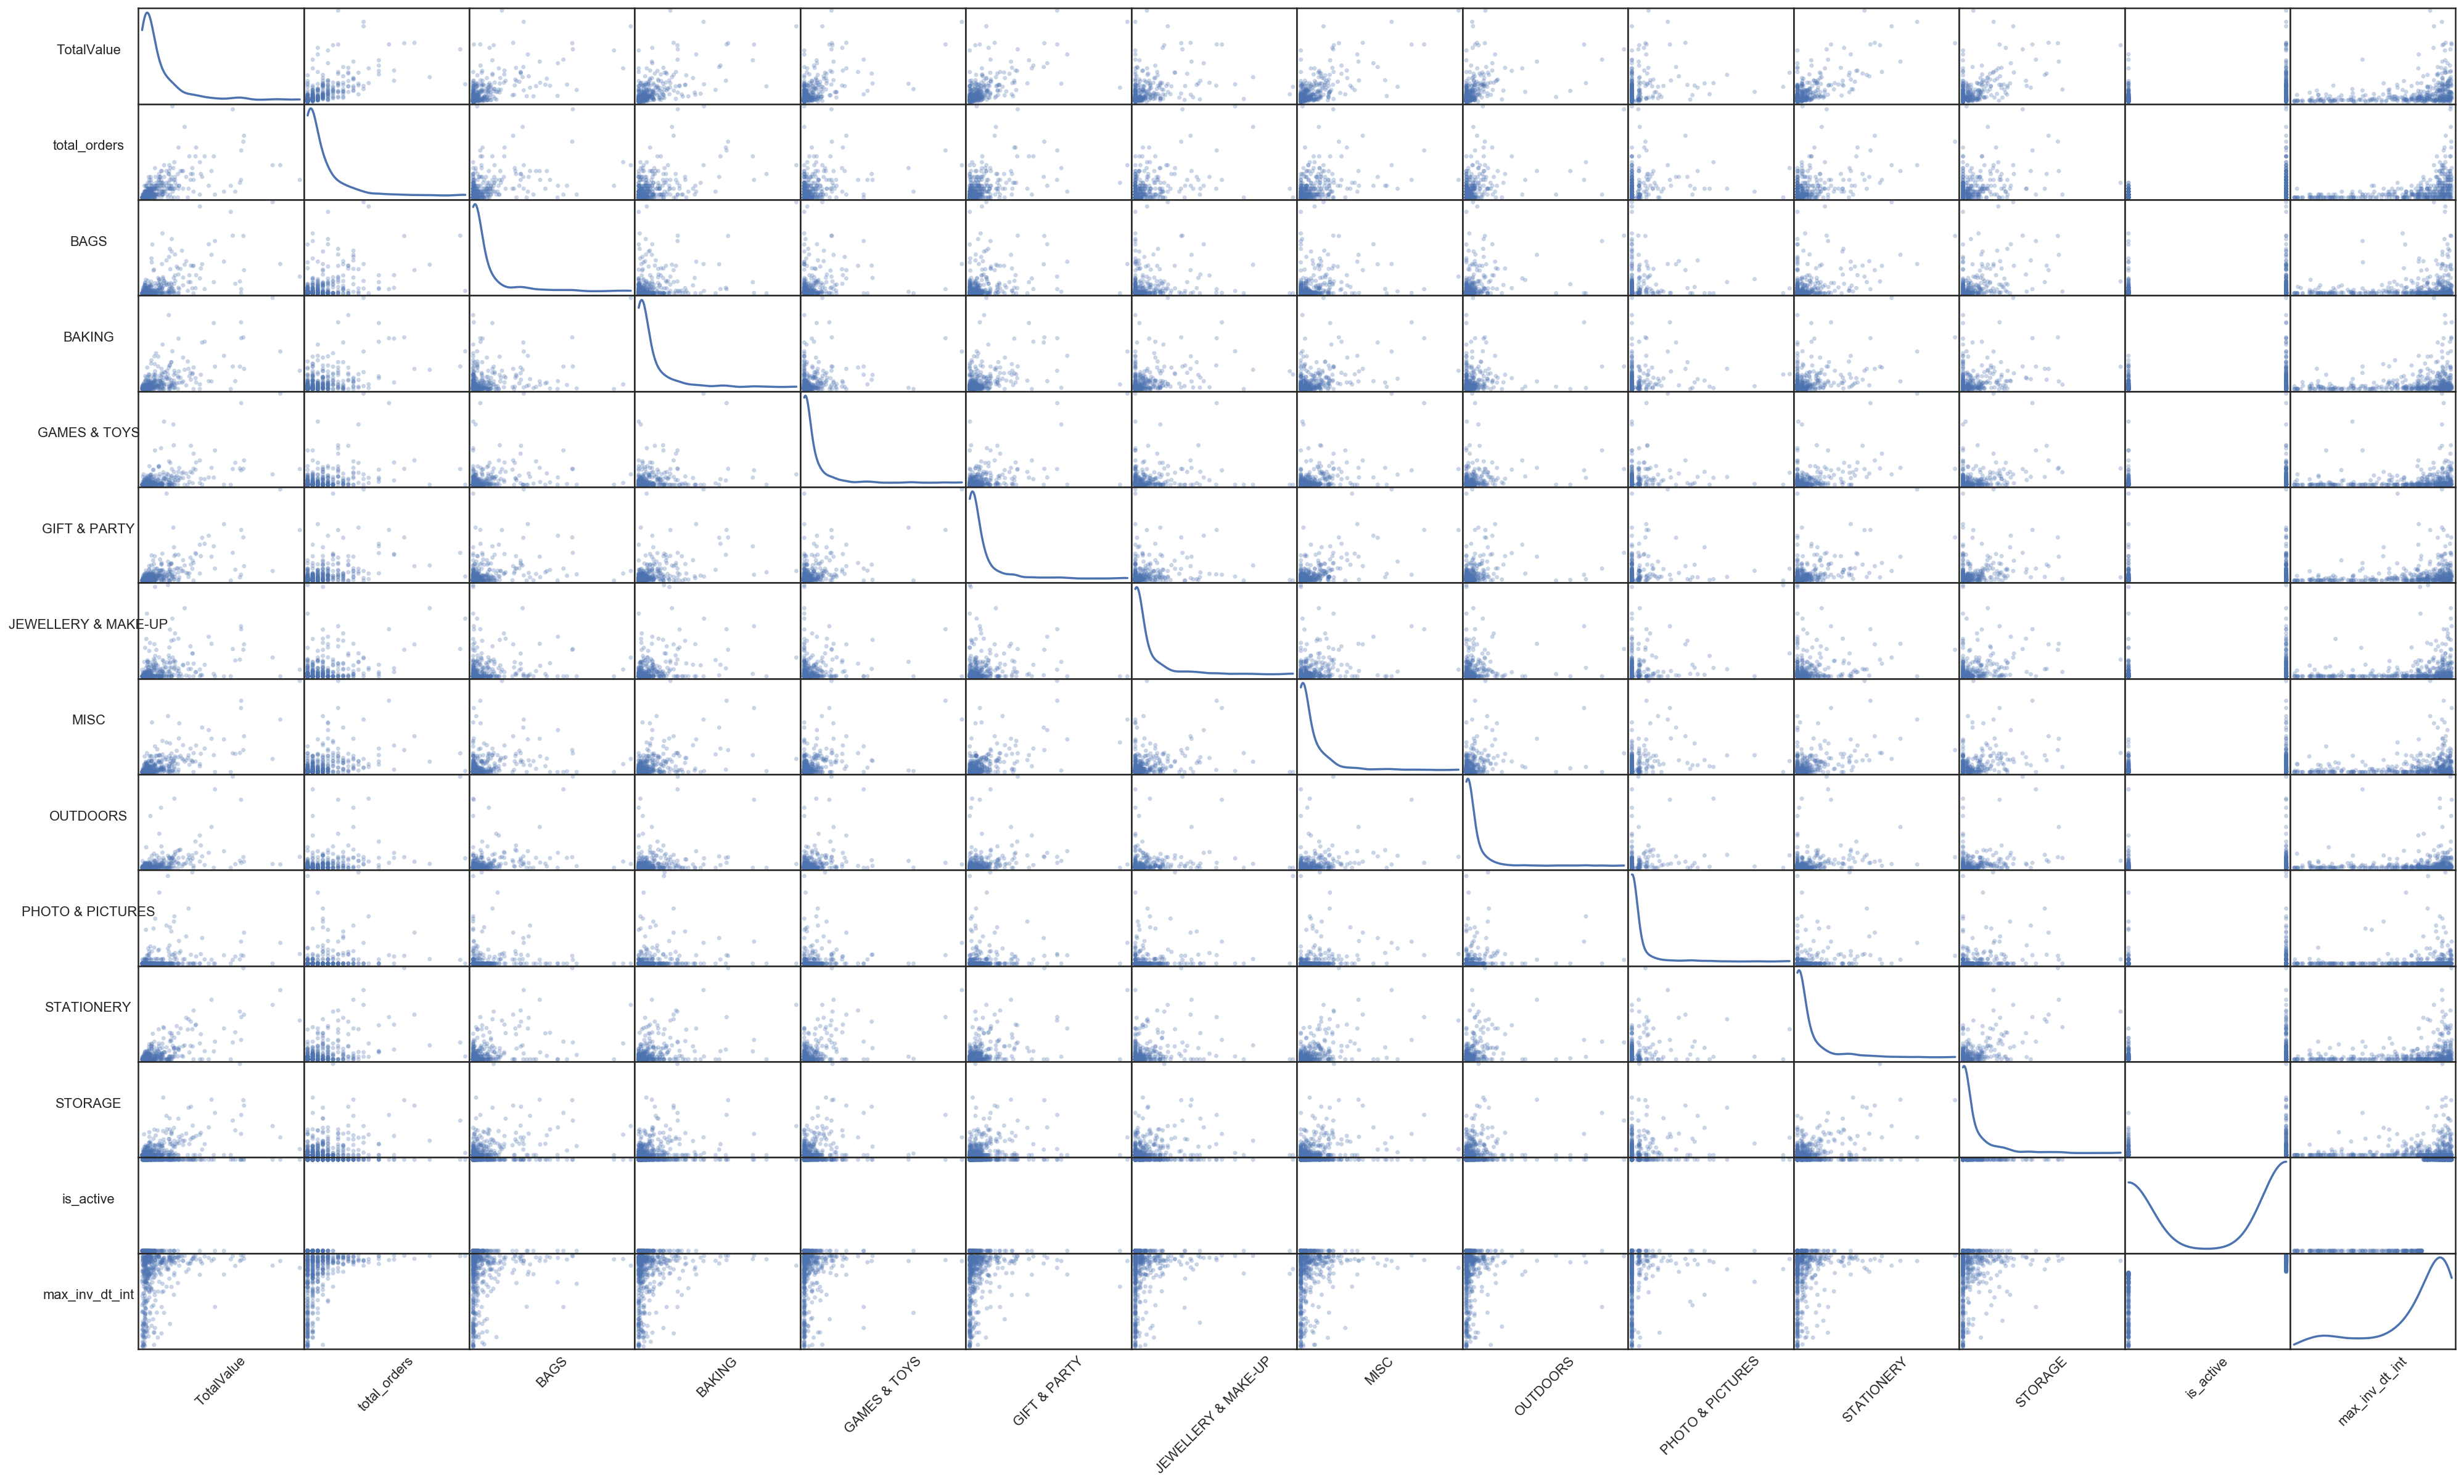

In [79]:
# Feature Distributions
# Produce a scatter matrix for each pair of features in the data
sm = pd.scatter_matrix(good_data, alpha = 0.3, figsize = (30,20), diagonal = 'kde');

#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

## 3. Fit the model

---

We are going to fit the model, with default parameters and all variables in the dataset, just to see how the clusters look like.
If the clusters are overlapping ar they don;t look ok, we are going to tune the model by changing the parameters.
if this is still not working, as a next step we are going to use PCA in order to reduce the dimensionality and final step: remove features.

In [95]:
#Defining fit kmeans model with number of cluster and daratfram parameters
def fit_kmeans_model(n_clusters,df):
  kmeans = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
      n_clusters=n_clusters, n_init=10, n_jobs=1, precompute_distances='auto',
      random_state=4552, tol=0.0001, verbose=0) #default
  # Fitting the input data
  #x=df_out.drop(columns='min_inv_dt', axis=1)
  #x=x.drop(columns='max_inv_dt', axis=1)
  #x=x.drop(columns='CustomerID', axis=1)
  kmeans = kmeans.fit(df)
  # or
  #kmeans = KMeans().fit(x)

  # Getting the cluster labels
  y_kmeans = kmeans.predict(df)
  # Centroid values
  #print('List of centers: ')
  print(' ')
  #centers = kmeans.cluster_centers_
  #print(centers)
  print(' ')
  print(' ')
  print('List of new clusters:')
  print(' ')
  print(y_kmeans)
  print('')
  #print('List of labels: ')
  labels = kmeans.labels_
  #print(labels)
  
  print('Inertia: \n')
  print(kmeans.inertia_)

  plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')

  centers = kmeans.cluster_centers_
  plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
  return y_kmeans
 

In [96]:
# check n_cluster with the elbow methode
def elbow_graph(df):
  sse = {}
  for k in range(1, 10):
      kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df)
      df["clusters"] = kmeans.labels_
      #print(data["clusters"])
      sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
  plt.figure()
  plt.plot(list(sse.keys()), list(sse.values()))
  plt.xlabel("Number of cluster")
  plt.ylabel("SSE")
  plt.show()

 
 
 
List of new clusters:
 
[7 2 1 0 1 0 0 2 1 1 5 4 1 0 7 2 1 0 1 7 1 2 0 1 1 0 2 2 1 1 2 1 0 7 2 1 2
 1 7 1 1 2 0 0 1 2 1 1 1 7 0 2 1 0 7 2 1 1 2 1 2 2 2 1 7 1 1 7 7 5 2 7 2 7
 1 0 1 7 1 1 0 1 1 2 7 1 2 4 2 1 1 2 2 1 1 1 1 2 7 7 7 1 4 7 1 1 1 7 1 7 1
 0 3 1 1 2 1 2 1 7 0 2 1 0 2 1 0 2 1 2 0 0 2 1 1 1 2 2 1 1 7 1 2 1 1 1 1 2
 2 7 1 7 6 1 1 2 1 2 2 2 0 1 3 1 3 1 0 1 0 3 0 0 2 6 7 1 1 0 0 1 1 1 2 0 1
 0 7 1 0 1 1 1 1 5 0 2 2 4 1 4 1 1 5 2 1 1 2 1 2 1 1 2 1 0 1 2 1 1 1 1 6 0
 0 2 2 7 3 1 1 1 1 2 7 1 0 1 2 1 7 2 1 1 7 2 2 1 0 0 2 1 3 1 1 1 1 7 1 0 1
 1 2 1 0 1 1 1 3 1 1 6 5 7 1 1 0 2 1 0 1 2 2 1 1 7 2 1 2 1 7 0 1 7 2 5 1 7
 2 1 2 2 1 7 1 2 1 1 0 1 7 2 2 6 2 0 0 0 0 0 2 1 2 6 2 2 0 0 2 3 3 1 1 2 0
 7 0 2 1 1 1 4 1 1 1 1 0 1 1 2 0 0 0 1 1 0 1 2 1 2 0 1 2 2 2 0 0 1 0 1 2 0
 0 2 1 0 1 2 1 1 2 3 1 1 1 4 2 1 1 0 2 2 1 4 1 0 2 0 7 1 2 0 0 2 2 2 1 0 2
 0 4 0 2]

Inertia: 

1649.8936684699129


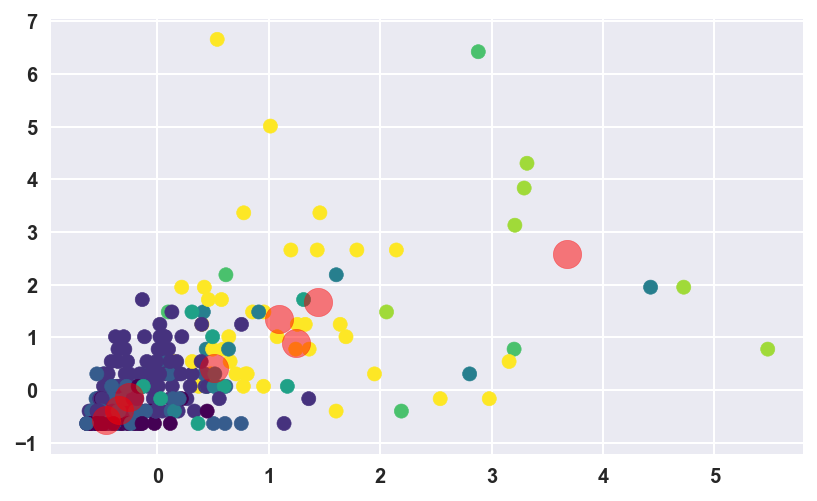

In [97]:
# 1st iteration with default parameters:8 
# fist value is the brakets is the number of clusters and second is the dataframe's name

y_kmeans=fit_kmeans_model(8,good_data)

Use the **elbow method** to identify the correct number of clusters:

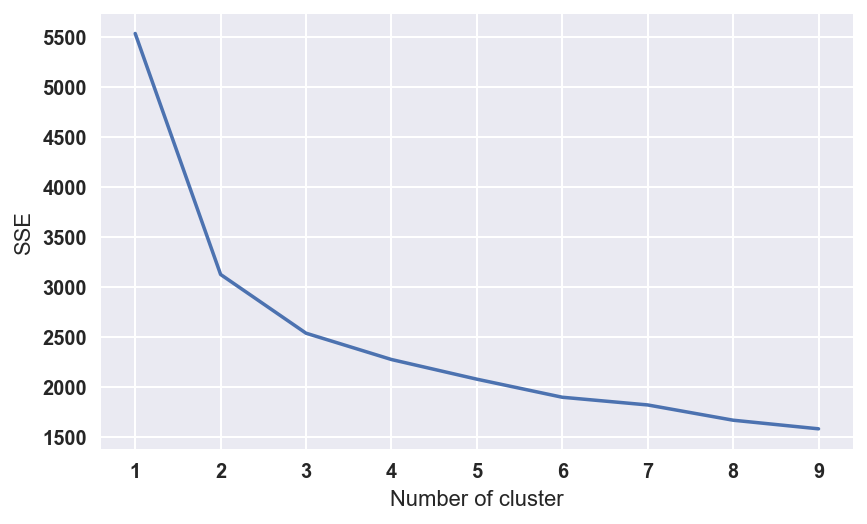

In [98]:
elbow_graph(good_data)

Based on the graph above, we are going to use n_clusters=3

 
 
 
List of new clusters:
 
[0 2 1 2 1 2 2 2 1 1 0 0 1 2 0 2 1 2 1 0 1 2 2 1 1 2 2 2 1 1 2 1 2 0 2 1 2
 1 1 1 1 2 2 2 1 2 1 1 1 0 2 2 1 2 1 2 1 1 2 1 2 2 2 1 0 1 1 0 0 0 2 0 2 0
 1 2 1 0 1 1 2 1 1 2 0 1 2 0 2 1 1 2 2 1 1 1 1 2 0 1 0 1 0 0 1 1 1 0 1 0 1
 2 0 1 1 2 1 2 1 0 2 2 1 2 2 1 2 2 1 2 2 2 2 1 1 1 2 2 1 1 0 1 2 1 1 1 1 2
 2 0 1 0 0 1 1 2 1 2 2 2 2 1 0 1 0 1 2 1 2 0 2 2 2 0 0 1 1 2 2 1 1 1 2 2 1
 2 0 1 2 1 1 1 1 0 2 2 2 0 1 0 1 1 0 2 1 1 2 1 2 1 1 2 1 2 1 2 1 1 1 1 0 2
 2 2 2 0 0 1 1 1 1 2 0 1 2 1 2 1 0 2 1 1 1 2 2 1 2 2 2 1 0 1 1 1 1 0 1 2 1
 1 2 1 2 1 1 1 0 1 1 0 0 0 1 1 2 2 1 2 1 2 2 1 1 0 2 1 2 1 0 2 1 0 2 0 1 0
 2 1 2 2 1 0 1 2 1 1 2 1 1 2 2 0 2 2 2 2 2 2 2 1 2 0 2 2 2 2 2 0 2 1 1 2 2
 0 2 2 1 1 1 0 1 1 1 1 2 1 1 2 2 2 2 1 1 2 1 2 1 2 2 1 2 2 2 2 2 1 2 1 2 2
 2 2 1 2 1 2 1 1 2 0 1 1 1 0 2 1 1 2 0 2 1 0 1 2 2 2 0 1 2 2 2 2 2 2 1 2 2
 2 0 2 2]

Inertia: 

2832.8338680499774


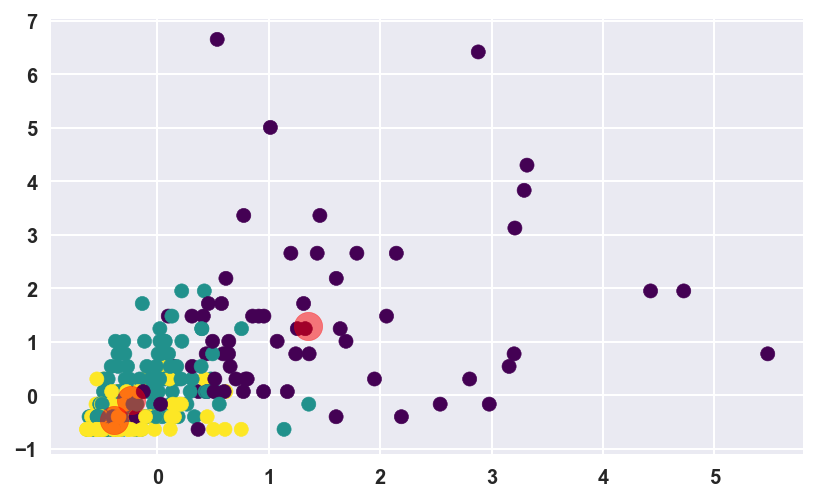

In [99]:
# 2nd iteration with amended parameters

y_kmeans=fit_kmeans_model(3,good_data)

**Conclusions:**
- although we tune the model, the result is similar to the previous one due to big dimensionality
- seems that the most of the clusters are overlapping and also two of them are way too disperse
- we now need to reduce this by using PCA

In [100]:
good_data.shape

(411, 15)

## PCA
- we are going to use PCA in order to reduce the number of features from 15 to n features, based on the best n-components method

In [101]:
# fit PCA and find the best n_components
pca = PCA()
array_std = pca.fit_transform(good_data)
array_std

array([[ 3.91837702, -0.02495662, -0.89593548, ...,  0.33408273,
        -0.42251885, -0.21207631],
       [-1.11910853, -0.722744  ,  0.44237343, ..., -0.04975847,
        -0.39836627,  0.11587628],
       [-0.54871511, -1.1085231 , -0.60982176, ..., -0.09709931,
         0.22483866,  0.07285636],
       ...,
       [ 3.54937943,  1.62989927, -3.09483684, ...,  0.14968397,
        -0.17255173,  0.18893503],
       [-0.914729  ,  2.08692489,  0.56108047, ..., -0.23778693,
        -0.06693522,  0.1431806 ],
       [-2.32137889,  0.17076754,  0.41307282, ...,  0.27131056,
        -0.11401618,  0.02511805]])

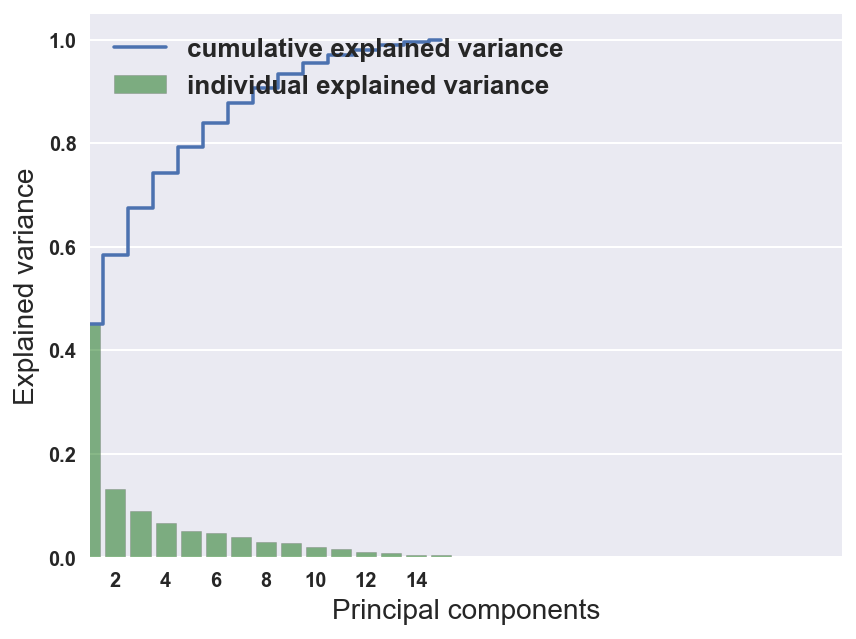

In [102]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.set(font_scale=1)
plt.step(range(good_data.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
        label='cumulative explained variance')
sns.barplot(np.arange(1,good_data.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
           label='individual explained variance')
plt.xlim(0, 30)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

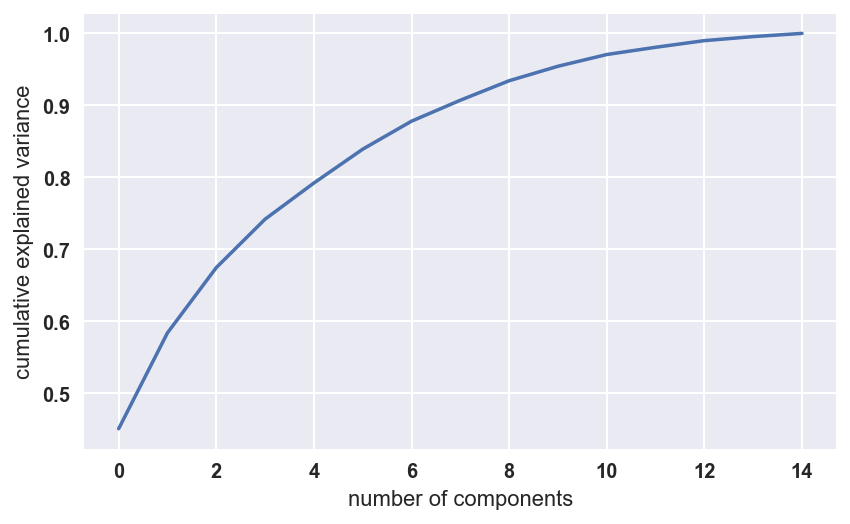

In [103]:
pca = PCA().fit(good_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Looking at the graphs above, we can see that the best number of components is 2

In [104]:
# use PCA and convert the output into a dataframe
pca = PCA(n_components=2)
array_std_n2 = pca.fit_transform(good_data)

df_std_n2=pd.DataFrame(array_std_n2)
#df_std_n2.columns = ["X","Y",]
#df_std_n2.head()


In [105]:

good_data.shape

(411, 15)

 
 
 
List of new clusters:
 
[0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0
 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 1 1]

Inertia: 

1086.8629099919185


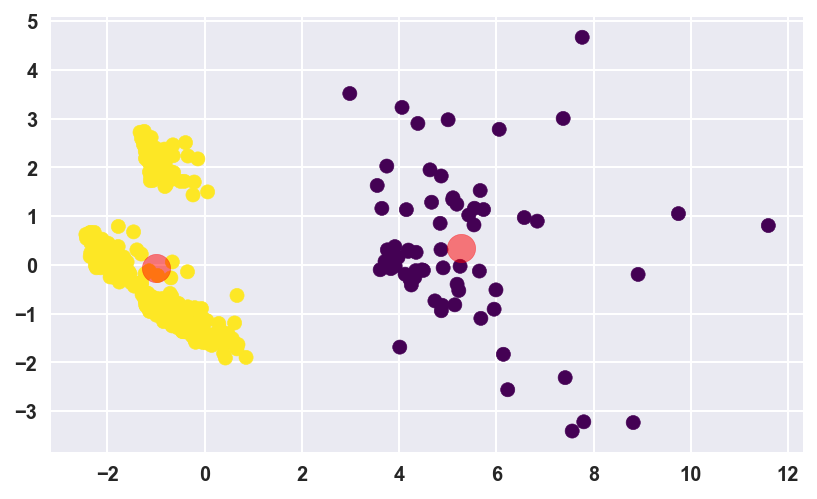

In [106]:
# 1st iteration after PCA

y_kmeans=fit_kmeans_model(2,df_std_n2)

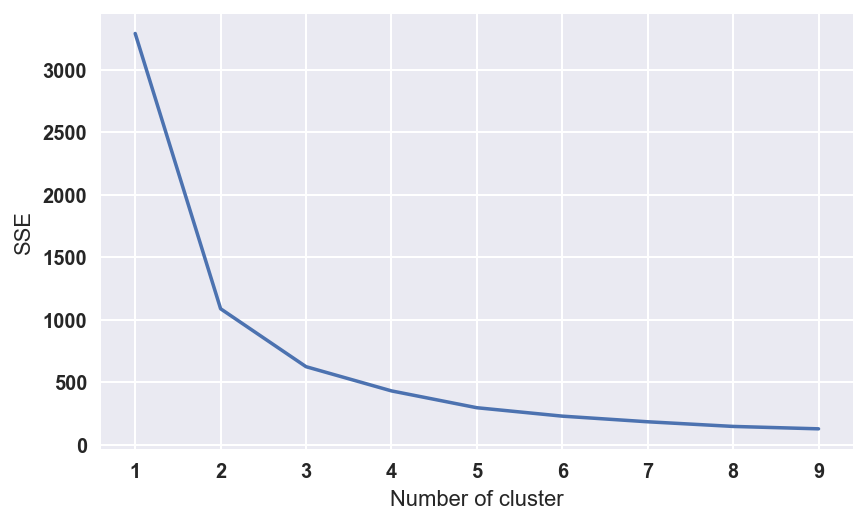

In [107]:
# check n_cluster with the elbow methode
elbow_graph(df_std_n2)

 
 
 
List of new clusters:
 
[0 2 2 1 2 1 1 1 2 2 3 3 2 1 0 1 2 1 2 0 2 1 1 2 2 1 2 1 2 2 1 2 1 0 1 2 1
 2 2 2 2 1 1 1 2 1 2 2 2 3 1 1 2 1 2 1 2 2 1 2 1 1 1 2 0 2 2 0 0 3 1 3 1 0
 2 1 2 0 2 2 1 2 2 1 0 2 1 3 2 2 2 1 1 2 2 2 2 1 0 2 0 2 3 0 2 2 2 0 2 0 2
 1 3 2 2 1 2 1 2 0 1 2 2 1 1 2 1 1 2 1 1 1 1 2 2 2 1 1 2 2 0 2 1 2 2 2 2 1
 1 0 2 0 0 2 2 1 2 1 1 1 1 2 3 2 3 2 1 2 1 3 1 1 1 0 0 2 2 1 1 2 2 2 1 1 2
 1 0 2 1 2 2 2 2 3 1 1 1 3 2 0 2 2 3 1 2 2 1 2 1 2 2 2 2 1 2 1 2 2 2 2 0 1
 1 1 1 0 3 2 2 2 2 1 0 2 1 2 1 2 0 1 2 2 2 1 1 2 1 1 1 2 3 2 2 2 2 0 2 1 2
 2 1 2 1 2 2 2 3 2 2 0 3 0 2 2 1 2 2 1 2 1 1 2 2 0 1 2 1 2 0 1 2 0 1 3 2 0
 1 2 1 1 2 0 2 1 2 2 1 2 2 1 1 0 1 1 1 1 1 1 1 2 1 0 1 1 1 1 1 3 2 2 2 1 1
 0 1 1 2 2 2 0 2 2 2 2 1 2 2 1 1 1 1 2 2 1 2 1 2 1 1 2 1 1 1 1 1 2 1 2 1 1
 1 2 2 1 2 1 2 2 1 3 2 2 2 3 1 2 2 1 3 1 2 3 2 1 1 1 0 2 1 1 1 1 1 1 2 1 2
 1 3 1 1]

Inertia: 

674.0210710029547


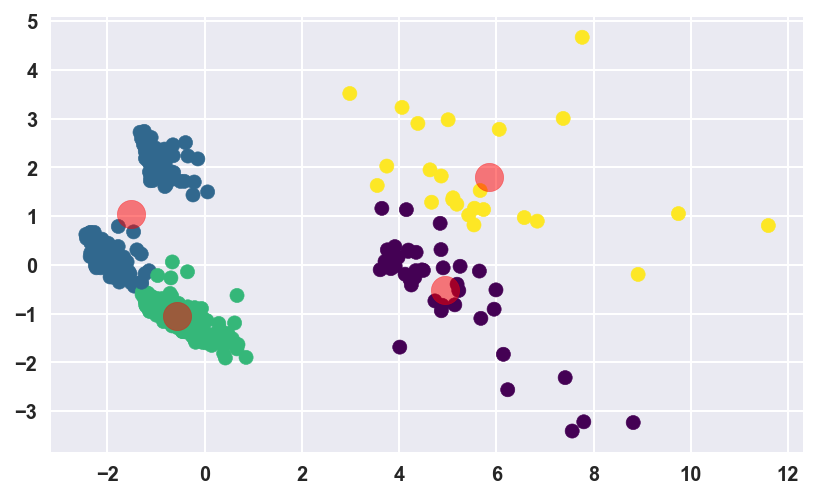

In [108]:
# 2nd iteration after PCA

y_kmeans=fit_kmeans_model(4,df_std_n2)


## 4. Data Recovery

In [109]:
# append the segments back to the final dataframe that contain unique customers
df_out['cluster'] = pd.Series(y_kmeans)
good_data['cluster'] = pd.Series(y_kmeans)
df_result['cluster'] = pd.Series(y_kmeans)

#df_out.head()

In [110]:
# describe each cluster 
cluster0=df_out[df_out['cluster']==0].describe()
cluster1=df_out[df_out['cluster']==1].describe()
cluster2=df_out[df_out['cluster']==2].describe()


#cluster0.to_csv('cluster_0.csv')
#cluster1.to_csv('cluster_1.csv')
#cluster2.to_csv('cluster_2.csv')

In [111]:
# run the Random Forest to double check the segmentation
X = good_data.drop(['cluster'], axis=1)
y = good_data['cluster']

x_train, x_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.30, random_state=1)
    
rf = RandomForestClassifier(n_estimators=5)
xx=rf.fit(x_train, y_train)

pred = rf.predict(x_test)
accuracy_score(y_test, pred)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[12  0  0  3]
 [ 0 46  0  0]
 [ 0  3 53  0]
 [ 3  1  1  2]]
             precision    recall  f1-score   support

          0       0.80      0.80      0.80        15
          1       0.92      1.00      0.96        46
          2       0.98      0.95      0.96        56
          3       0.40      0.29      0.33         7

avg / total       0.90      0.91      0.91       124



As a double check, we've used Randon Forest algorithm in order to see how good our segmentation is.
As you can see from the classification report, the 3rd cluster (name cluster 2) is perfect, but the other three clusters are not that perfect, mainly the 2nd one (name cluster 1) has a lower recall.

In [112]:
x1 = df_result.groupby(by=['cluster'], as_index=False)['total_orders'].count()
x1.head()

cluster  total_orders
0      0.0            41
1      1.0           162
2      2.0           183
3      3.0            25

In [113]:
print(rf.feature_importances_)
print(rf.estimator_params)

[0.0851034  0.03135739 0.02863589 0.03016014 0.0135921  0.06126728
 0.02064258 0.03467022 0.01840389 0.02173019 0.02812012 0.01766976
 0.1430458  0.28192757 0.18367367]
('criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'random_state')
